In [4]:
import awkward as ak
import numpy as np
import uproot as uproot
import matplotlib.pyplot as plt
import mplhep as hep
import vector as vec

import matplotlib as mpl

plt.style.use(hep.style.CMS)
%matplotlib inline

In [5]:
filename = '/eos/user/a/aperego/tagger/tree_DY_10k.root'
file = uproot.open(filename)

In [6]:
file.keys()

['GenParticles;3', 'GenParticles;2', 'LHEParticles;1', 'GenJets;1']

In [7]:
f_LHEParticles = file["LHEParticles;1"]
f_GenJets = file["GenJets;1"]
f_GenParticles = file["GenParticles;3"]

In [8]:
print(f_LHEParticles.keys())
print(f_GenJets.keys())
print(f_GenParticles.keys())

['LHEPart_pt', 'LHEPart_eta', 'LHEPart_phi', 'LHEPart_mass', 'LHEPart_pdgId', 'LHEPart_status']
['GenJet_pt', 'GenJet_eta', 'GenJet_phi', 'GenJet_mass', 'GenJet_nConstituents', 'GenJet_constituents']
['nGenPart', 'GenPart_pt', 'GenPart_eta', 'GenPart_phi', 'GenPart_mass', 'GenPart_pdgId']


In [9]:
LHEParticles = f_LHEParticles.arrays(f_LHEParticles.keys())
GenJets = f_GenJets.arrays(f_GenJets.keys())
GenParticles = f_GenParticles.arrays(f_GenParticles.keys())

In [10]:
def getJetConstituents(i, nConst, allConst):
    return allConst[sum(nConst[:i]):sum(nConst[:i+1])]

In [11]:
def getManyJetsConstituents(i, j, nConst, allConst):
    return allConst[sum(nConst[:i]):sum(nConst[:j+1])]

In [12]:
getManyJetsConstituents(0,3, GenJets.GenJet_nConstituents[0], GenJets.GenJet_constituents[0])

<Array [692, 378, 689, 376, ... 261, 33, 140] type='125 * int32'>

In [13]:
def plot_hist(data, collection_name, log =False):
    # Determine the title based on the collection name
    title = collection_name.replace("_", " ").title()
    
    # Flatten the data collection
    try:
        collection_data = ak.flatten(data)
    except:
        collection_data = data
        
    # Convert to a NumPy array for easy manipulation
    collection_data = ak.to_numpy(collection_data)
    
    # Remove infinite values
    collection_data = collection_data[np.isfinite(collection_data)]
    # Plot the histogram
    plt.figure(dpi=100)
    plt.hist(collection_data, bins=30)  # Adjust the number of bins as needed
    plt.title(title)
    plt.xlabel(title)
    plt.ylabel('Counts / bin')
    if log or "pt" in collection_name:
        plt.yscale("log")
    plt.show()

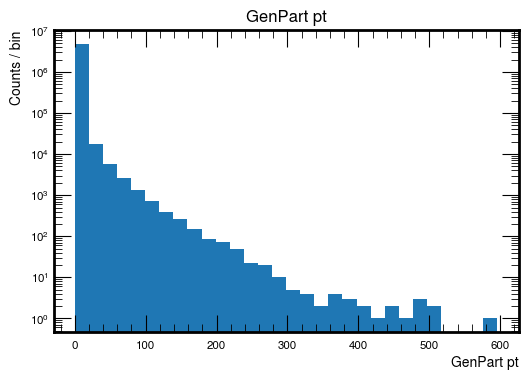

In [14]:
plt.figure(dpi=100)
plt.hist(ak.flatten(GenParticles.GenPart_pt), bins=30)  # Adjust the number of bins as needed
plt.title("GenPart pt")
plt.xlabel("GenPart pt")
plt.ylabel('Counts / bin')
plt.yscale("log")
plt.show()

## gen jets plots

In [15]:
jets2_pt = []
jets3_pt = []
jets2_eta = []
jets3_eta = []
jets2_phi = []
jets3_phi = []
jets2_mass = []
jets3_mass = []

for jets in GenJets.GenJet_pt:
    jets2_pt.extend(jets[:2])
    jets3_pt.extend(jets[:3])

for eta in GenJets.GenJet_eta:
    jets2_eta.extend(eta[:2])
    jets3_eta.extend(eta[:3])

for phi in GenJets.GenJet_phi:
    jets2_phi.extend(phi[:2])
    jets3_phi.extend(phi[:3])

for mass in GenJets.GenJet_mass:
    jets2_mass.extend(mass[:2])
    jets3_mass.extend(mass[:3])

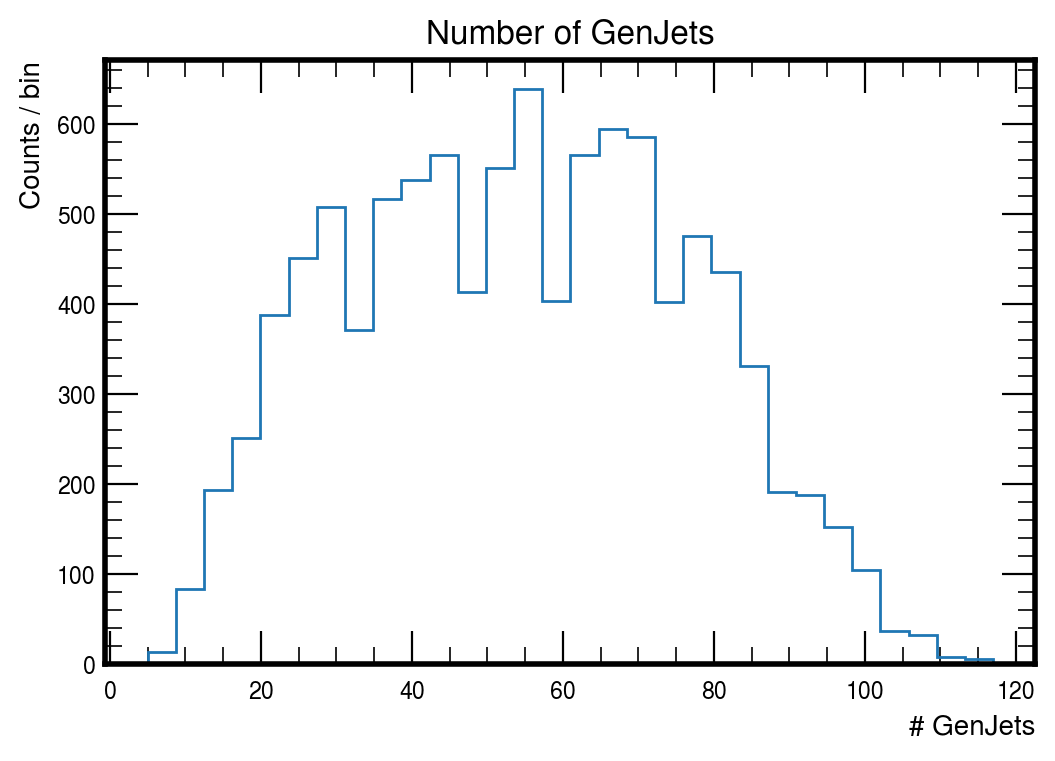

In [16]:
plt.figure(dpi=200)
plt.title("Number of GenJets")
plt.xlabel("# GenJets")
plt.ylabel('Counts / bin')

all_jets = ak.count(GenJets.GenJet_pt, axis=1)
ran = (ak.min(all_jets), ak.max(all_jets))
plt.hist(all_jets, bins=30, histtype="step", range=ran)

plt.show()

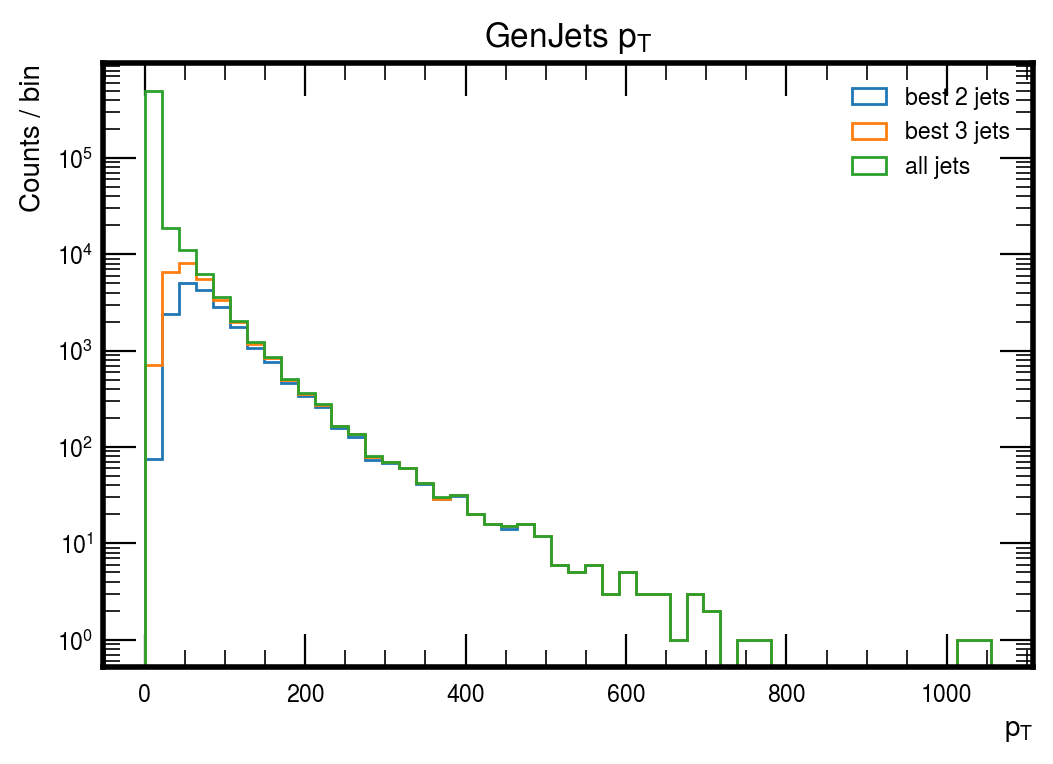

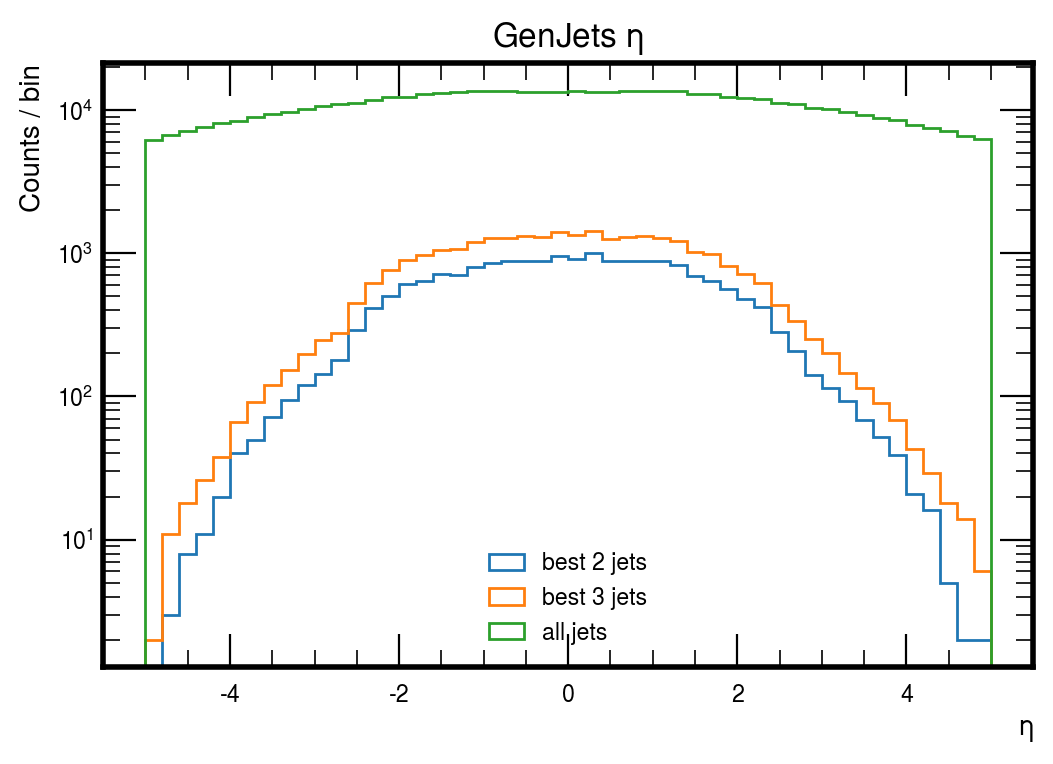

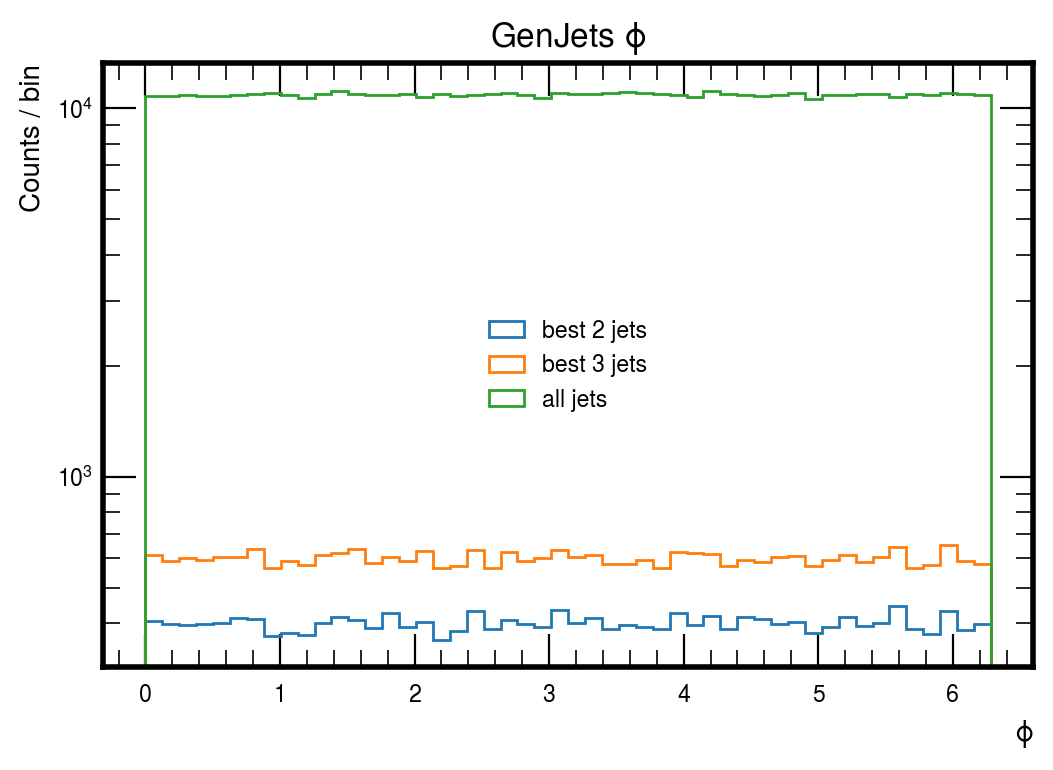

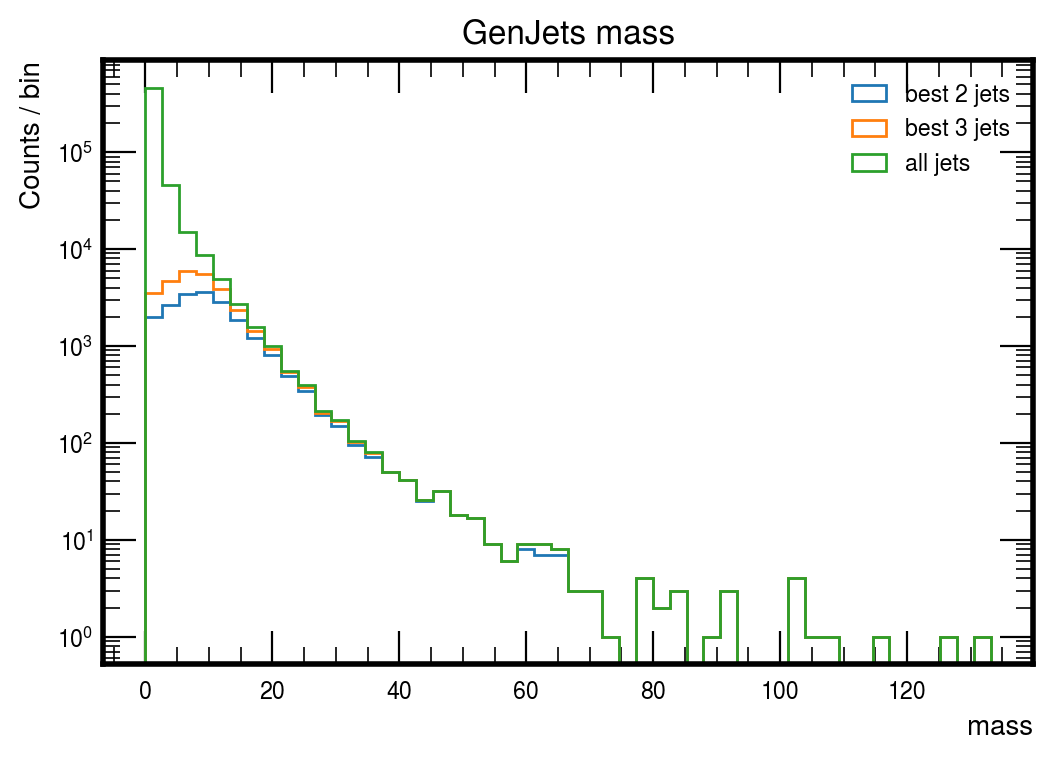

In [17]:
collections = {
    'GenJets $p_T$': (jets2_pt, jets3_pt, ak.flatten(GenJets.GenJet_pt)),
    'GenJets $\eta$': (jets2_eta, jets3_eta, ak.flatten(GenJets.GenJet_eta)),
    'GenJets $\phi$': (jets2_phi, jets3_phi, ak.flatten(GenJets.GenJet_phi)),
    'GenJets mass': (jets2_mass, jets3_mass, ak.flatten(GenJets.GenJet_mass))
}

for title, (jets2, jets3, all_jets) in collections.items():
    plt.figure(dpi=200)
    plt.title(title)
    plt.xlabel(title.split(' ')[1])
    plt.ylabel('Counts / bin')
    
    ran = (ak.min(all_jets), ak.max(all_jets))
    plt.hist(jets2, bins=50, label="best 2 jets", histtype="step", range=ran)
    plt.hist(jets3, bins=50, label="best 3 jets", histtype="step", range=ran)
    plt.hist(all_jets, bins=50, label="all jets", histtype="step", range=ran)
    
    plt.legend()
    if "p_T" or "eta" in title:
        plt.yscale("log")
    plt.show()

## genJets constituents

In [18]:
def wrapInPhi(phi):
    """Map angle values to the range [-pi, pi]."""
    return (phi + np.pi) % (2 * np.pi) - np.pi

def fixWrap(particlesPhi, ref):
    particlesPhi = np.asarray(particlesPhi)
    ref = np.asarray(ref)
    # Create mask where the absolute difference is greater than pi
    mask = np.abs(particlesPhi - ref) > np.pi
    # Adjust the values
    adjust_pos = mask & (particlesPhi > ref)
    adjust_neg = mask & (particlesPhi < ref)

    particlesPhi[adjust_pos] -= 2 * np.pi
    particlesPhi[adjust_neg] += 2 * np.pi
    
    return particlesPhi

def compute_dR(eta1, phi1, eta2, phi2):
    dphi = phi1 - phi2
    deta = eta1 - eta2
    return np.sqrt(dphi**2 + deta**2)

def plot_particles_in_jets_withLHE(jets_pt, jets_eta, jets_phi, particles_eta, particles_phi, LHE_eta, LHE_phi, radius=0.4):
    """axs, """ 
    num_jets= len(jets_pt)
#     if num_jets == 1:
#         axs = [axs]
    
    fig, axs = plt.subplots(1, num_jets, figsize=(num_jets * 6, 6), dpi=300)
        
    for i in range(num_jets):
        jet_pt = jets_pt[i]
        jet_eta = jets_eta[i]
        jet_phi = wrapInPhi(jets_phi[i])
        
        # Assuming particles_eta and particles_phi are lists of lists, where each sublist contains particles for the corresponding jet
        jet_particles_eta = particles_eta[i]
        jet_particles_phi = fixWrap(particles_phi[i], jet_phi)

        # Plot jets with different markers and colors
        axs[i].scatter(jet_eta, jet_phi, color='red', marker='o', label=f'genJet ($p_T$ = {jet_pt:.2f} GeV)')

        # Plot particles with different markers and colors
        axs[i].scatter(jet_particles_eta, jet_particles_phi, color='blue', marker='x', label='genParticles')

        # Draw circle around jet
        circle = plt.Circle((jet_eta, jet_phi), radius, color='red', fill=False, linestyle='--', label="ak4")
        axs[i].add_patch(circle)
        
        # Compute dR for LHE particles
        LHE_phi = fixWrap(LHE_phi, jet_phi)
        dR = compute_dR(LHE_eta, LHE_phi, jet_eta, jet_phi)
        matched_LHE_indices = np.where(dR < radius)[0]
        matched_LHE_eta = LHE_eta[matched_LHE_indices]
        matched_LHE_phi = LHE_phi[matched_LHE_indices]
        
        # Plot LHE particles with different markers and colors
        axs[i].scatter(matched_LHE_eta, matched_LHE_phi, color='green', marker='s', label='LHEParticle')

        # Adding labels and legend
        axs[i].set_xlabel('$\eta$')
        axs[i].set_ylabel('$\phi$')
        axs[i].set_title(f'GEN and LHE Particles in genJet {i+1}')
        axs[i].legend()

        # Set the same scale for both axes for better visualization
        axs[i].axis('equal')

    plt.tight_layout()
#     plt.savefig("jetConstituents_"+str(jet_pt)+".png")
    plt.show()

---


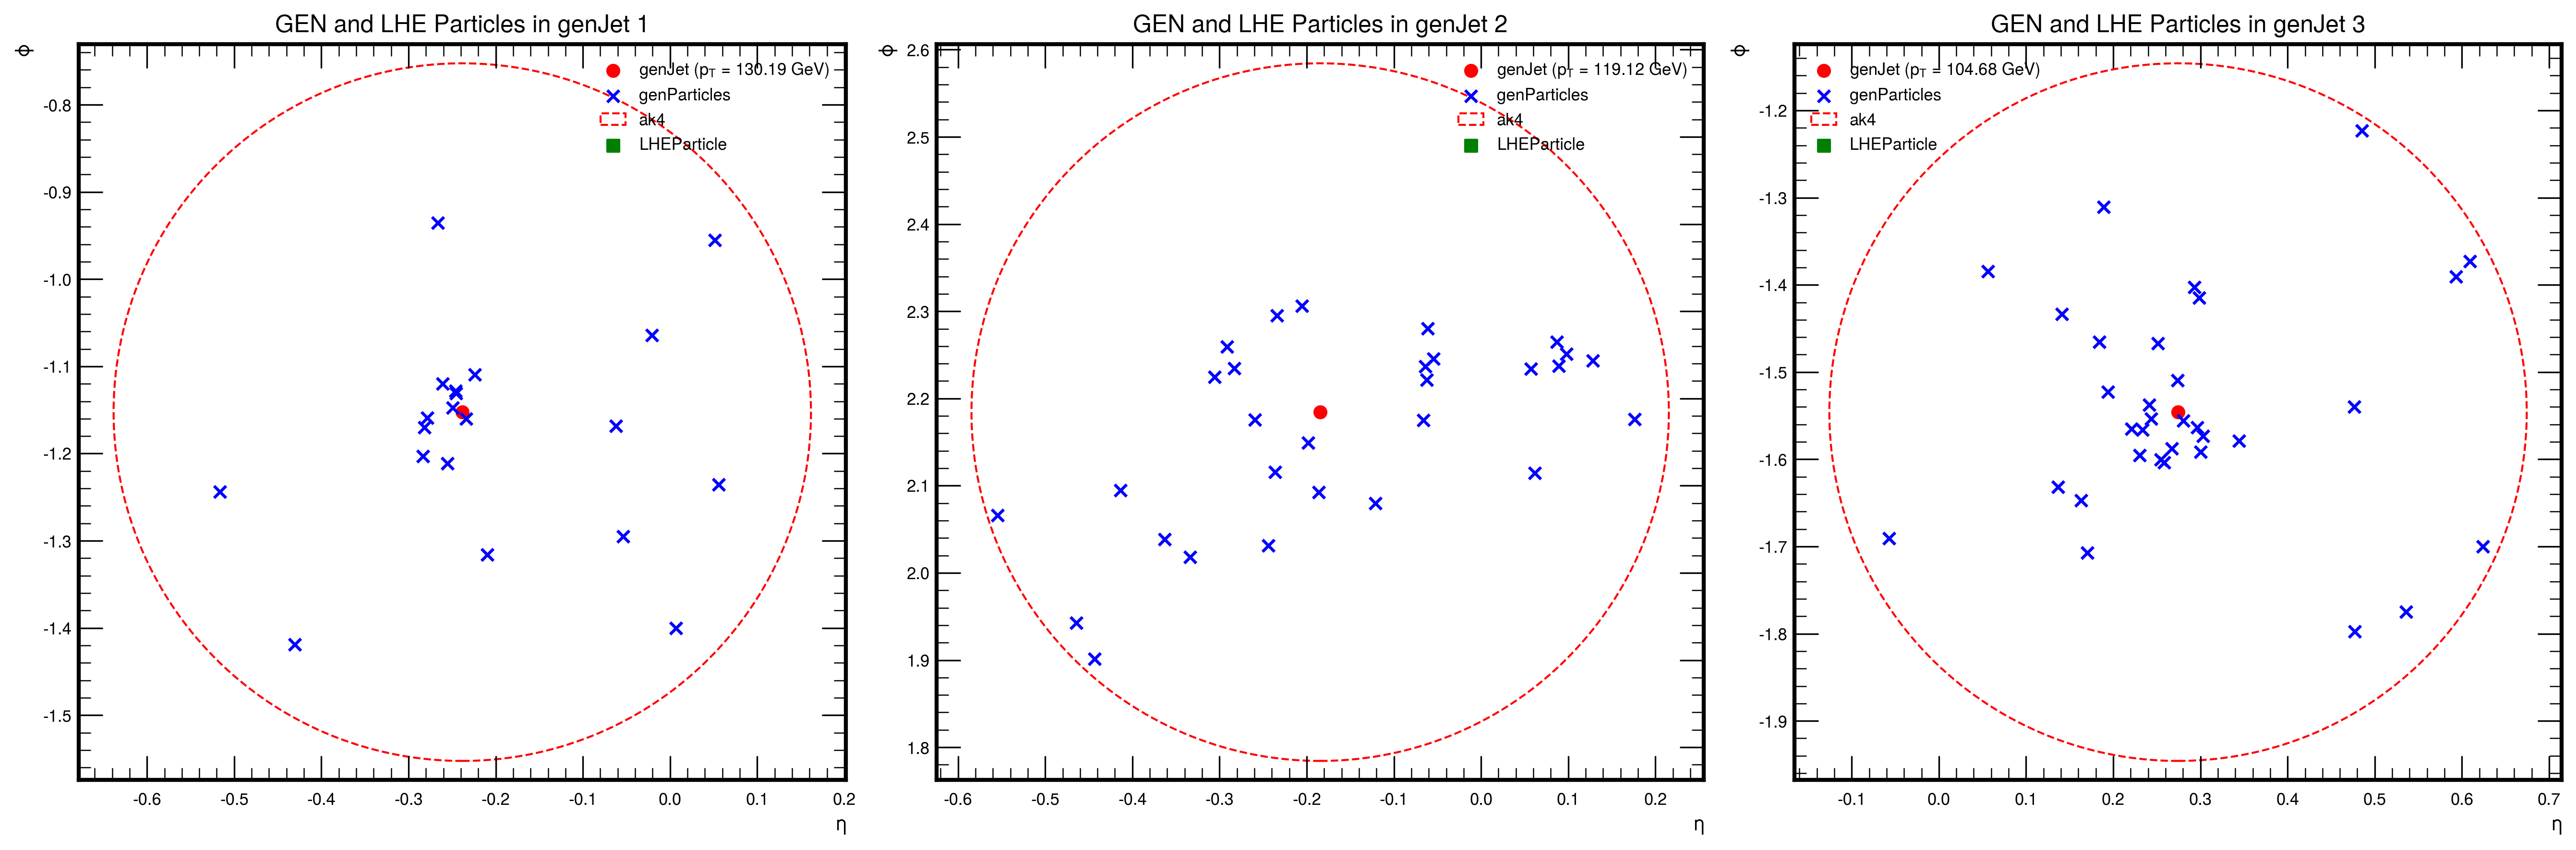

---


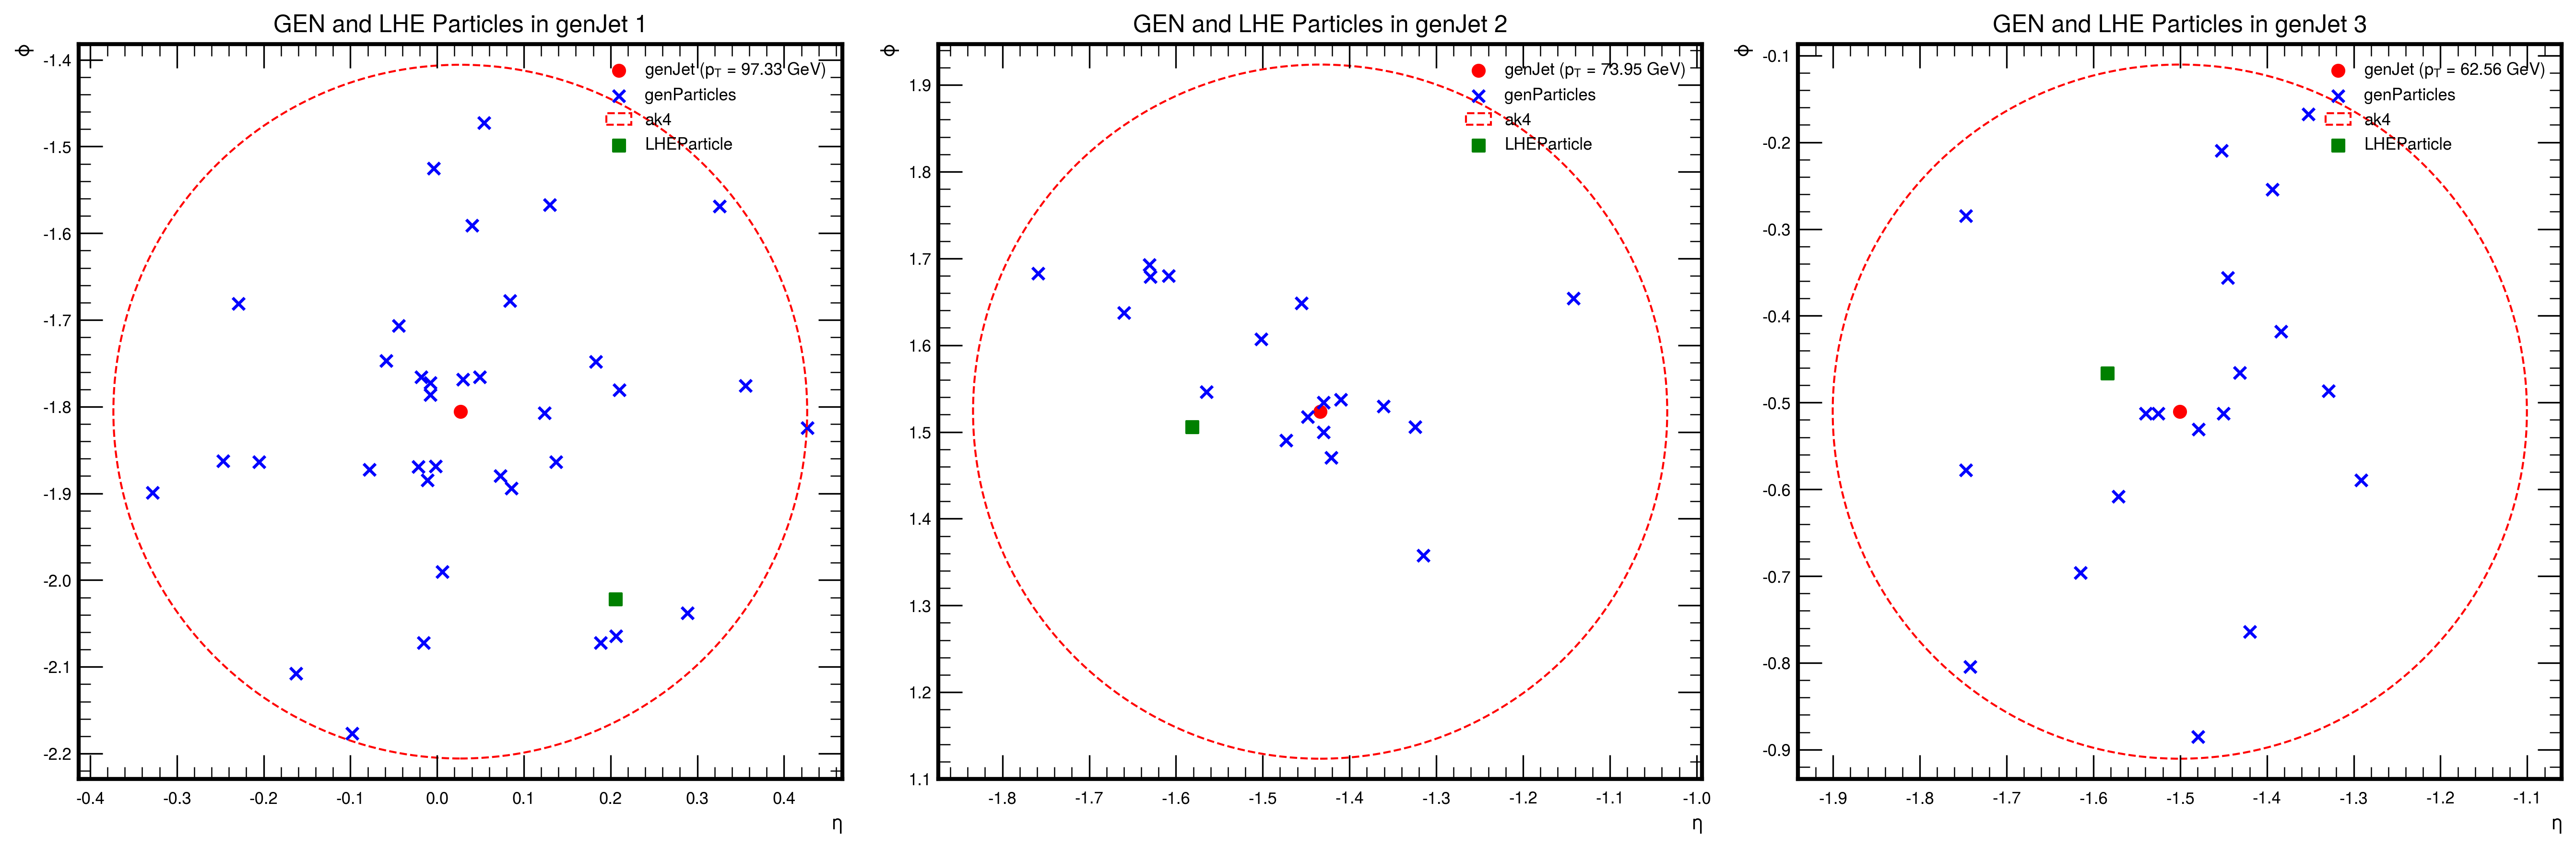

---


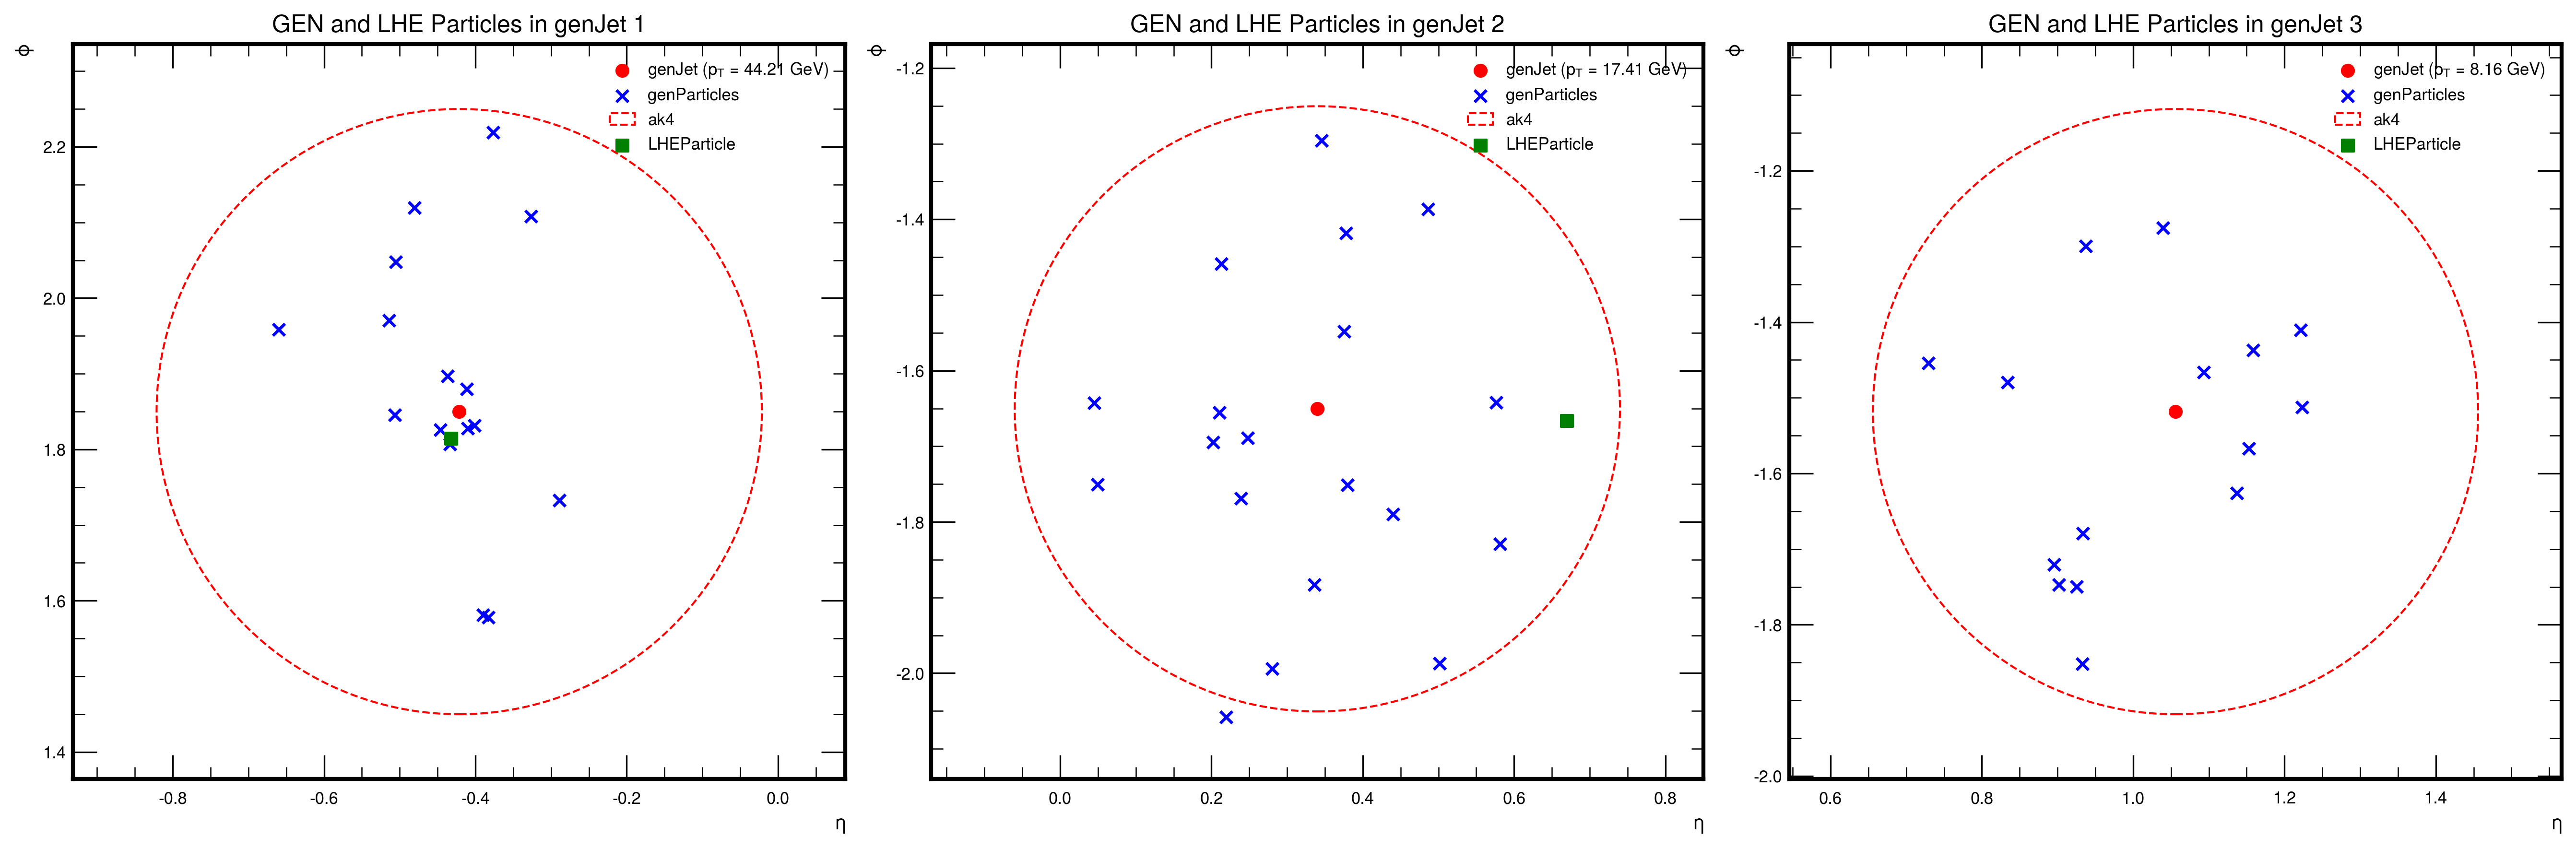

---


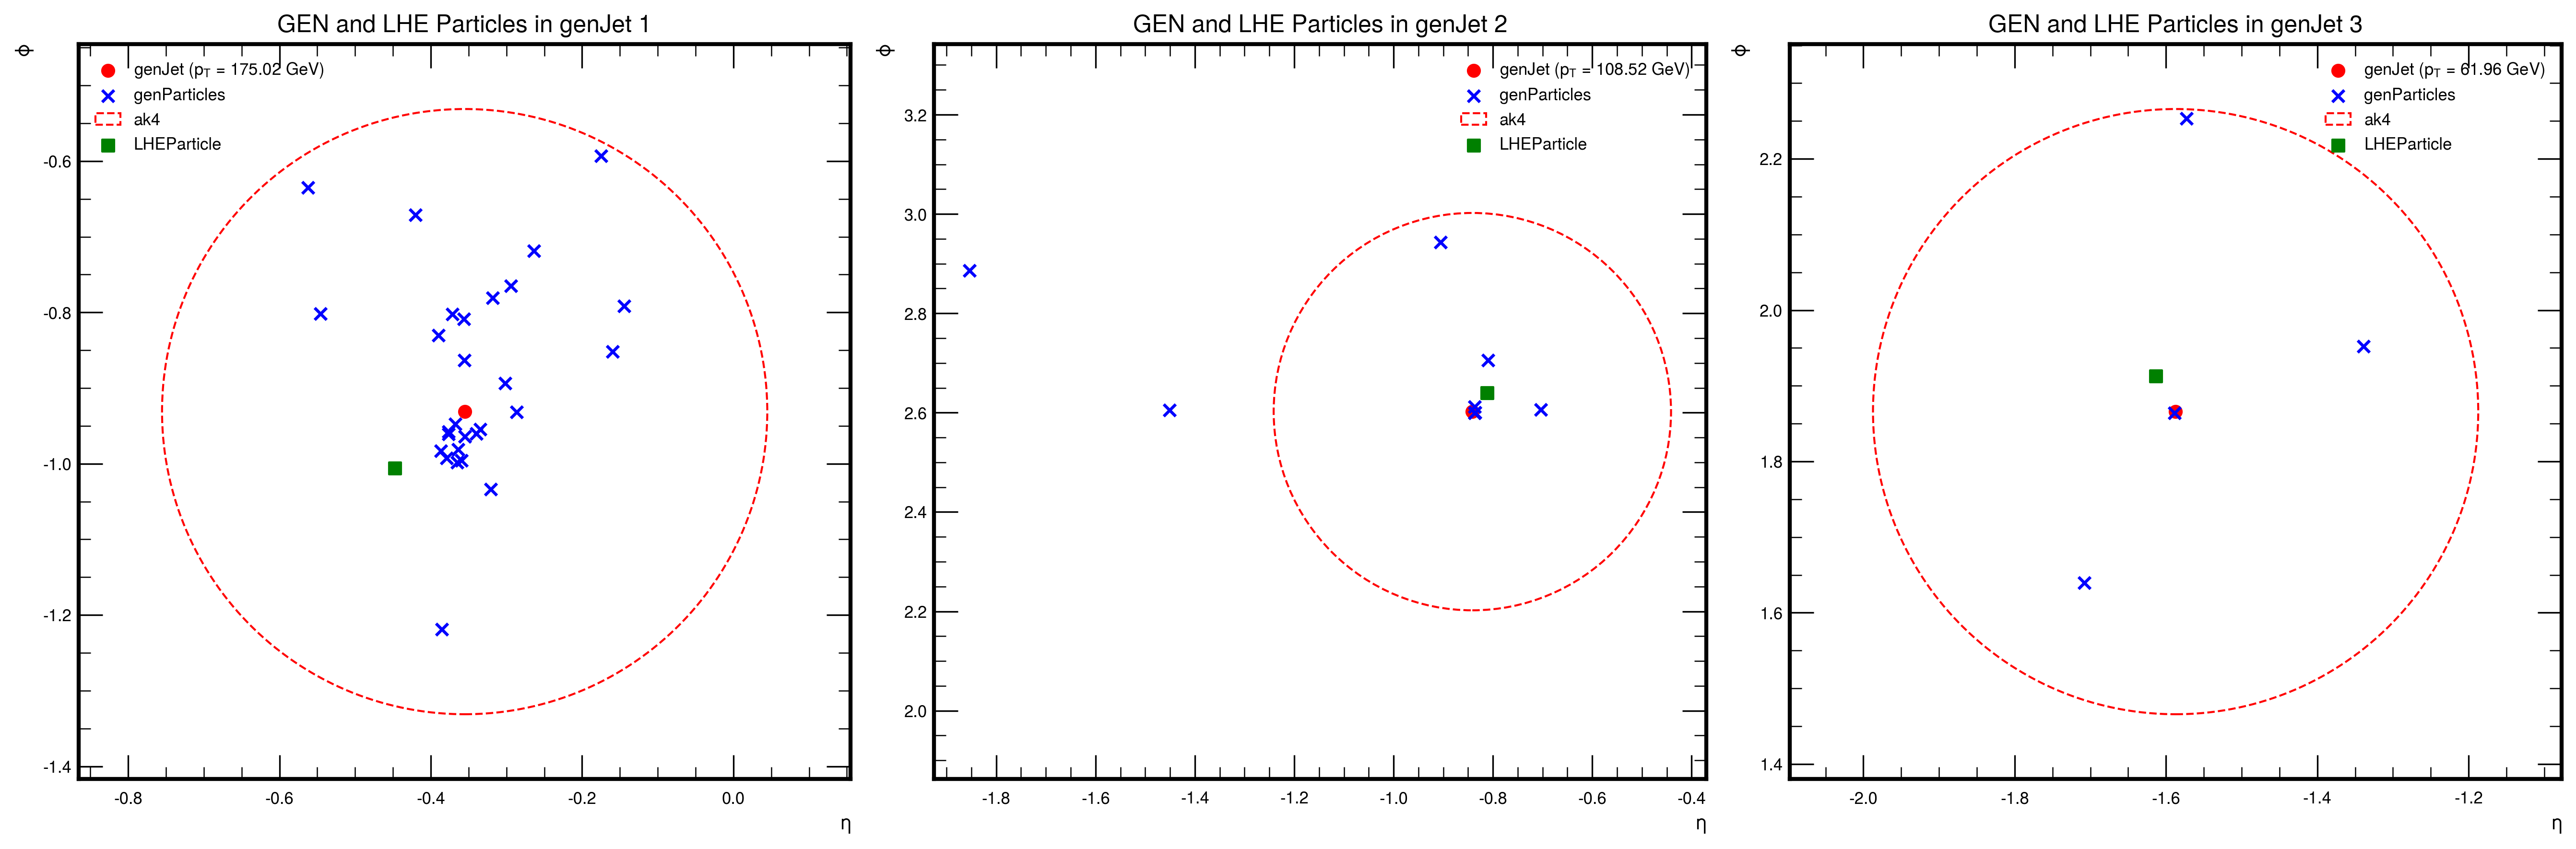

---


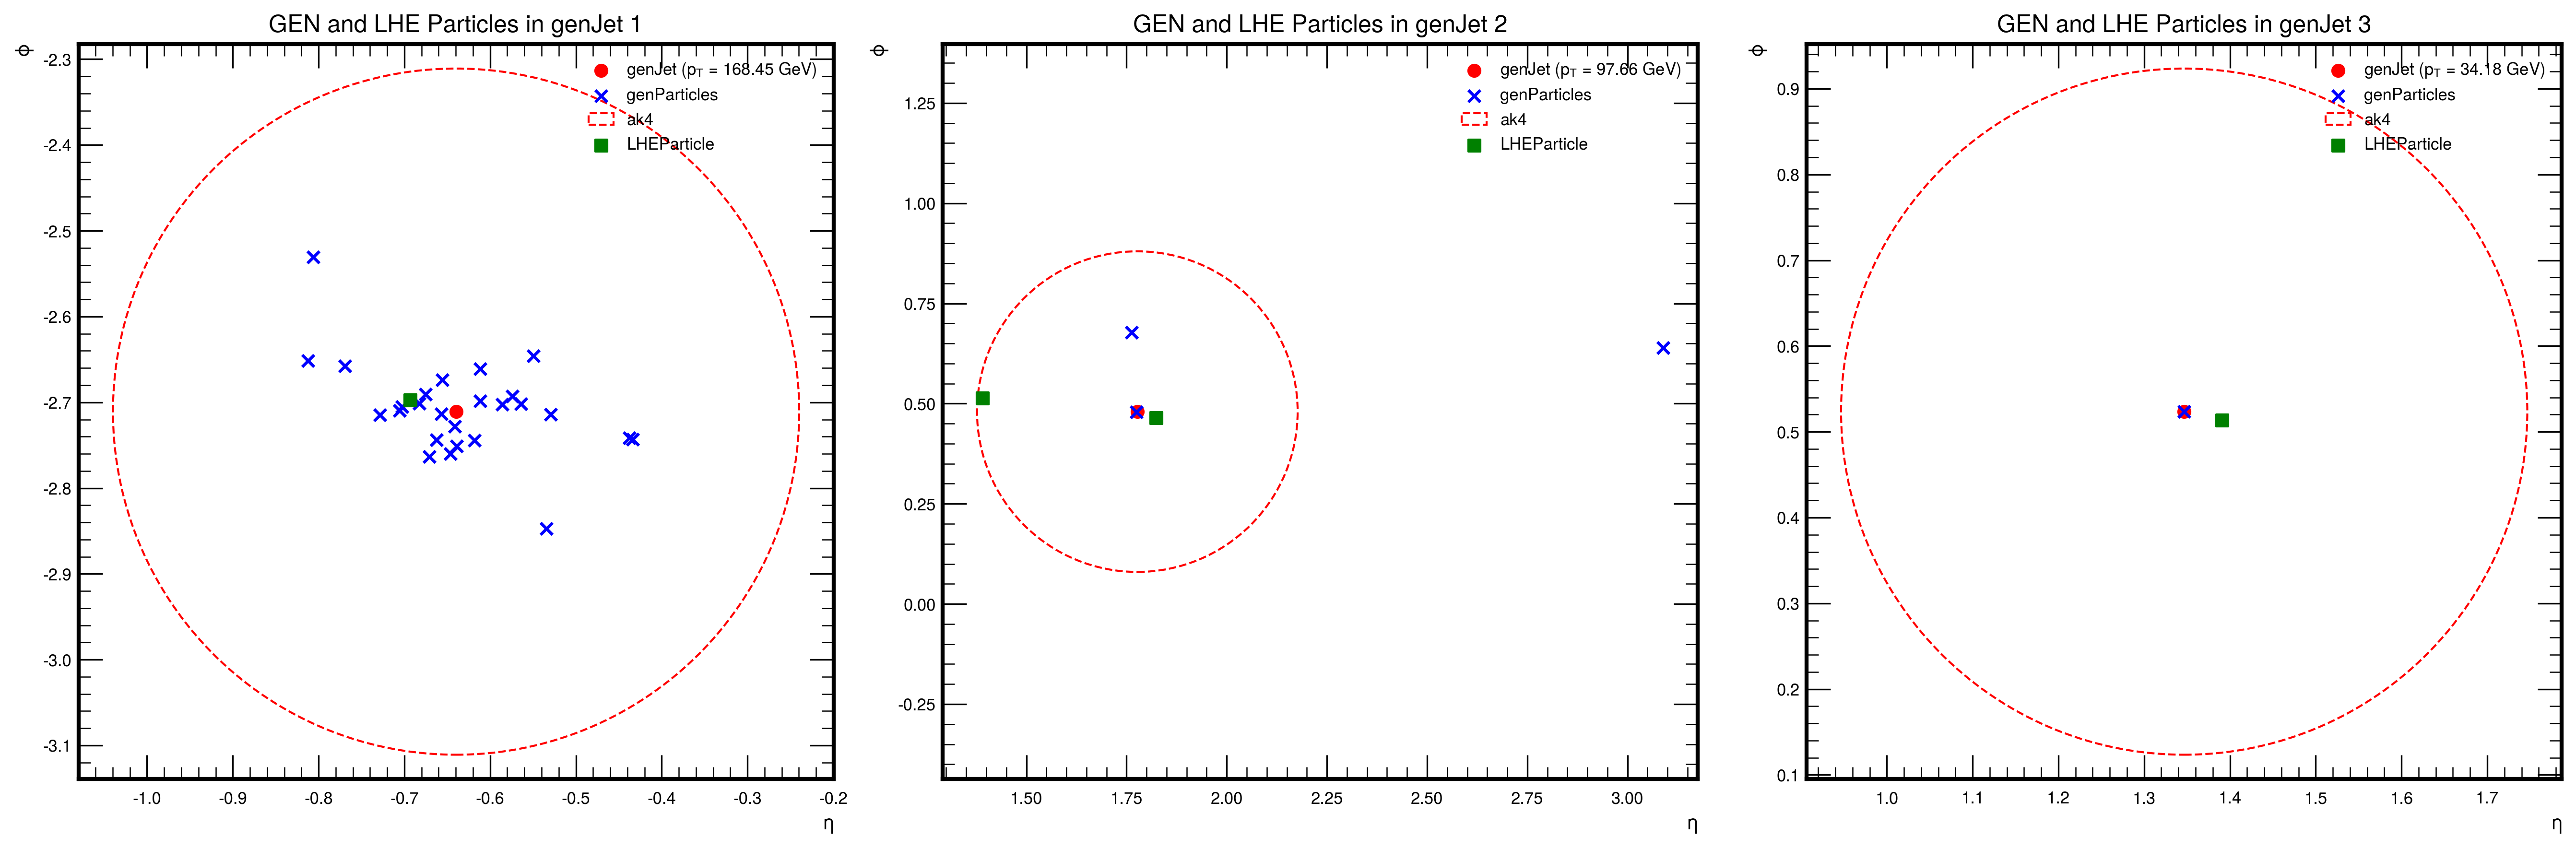

---


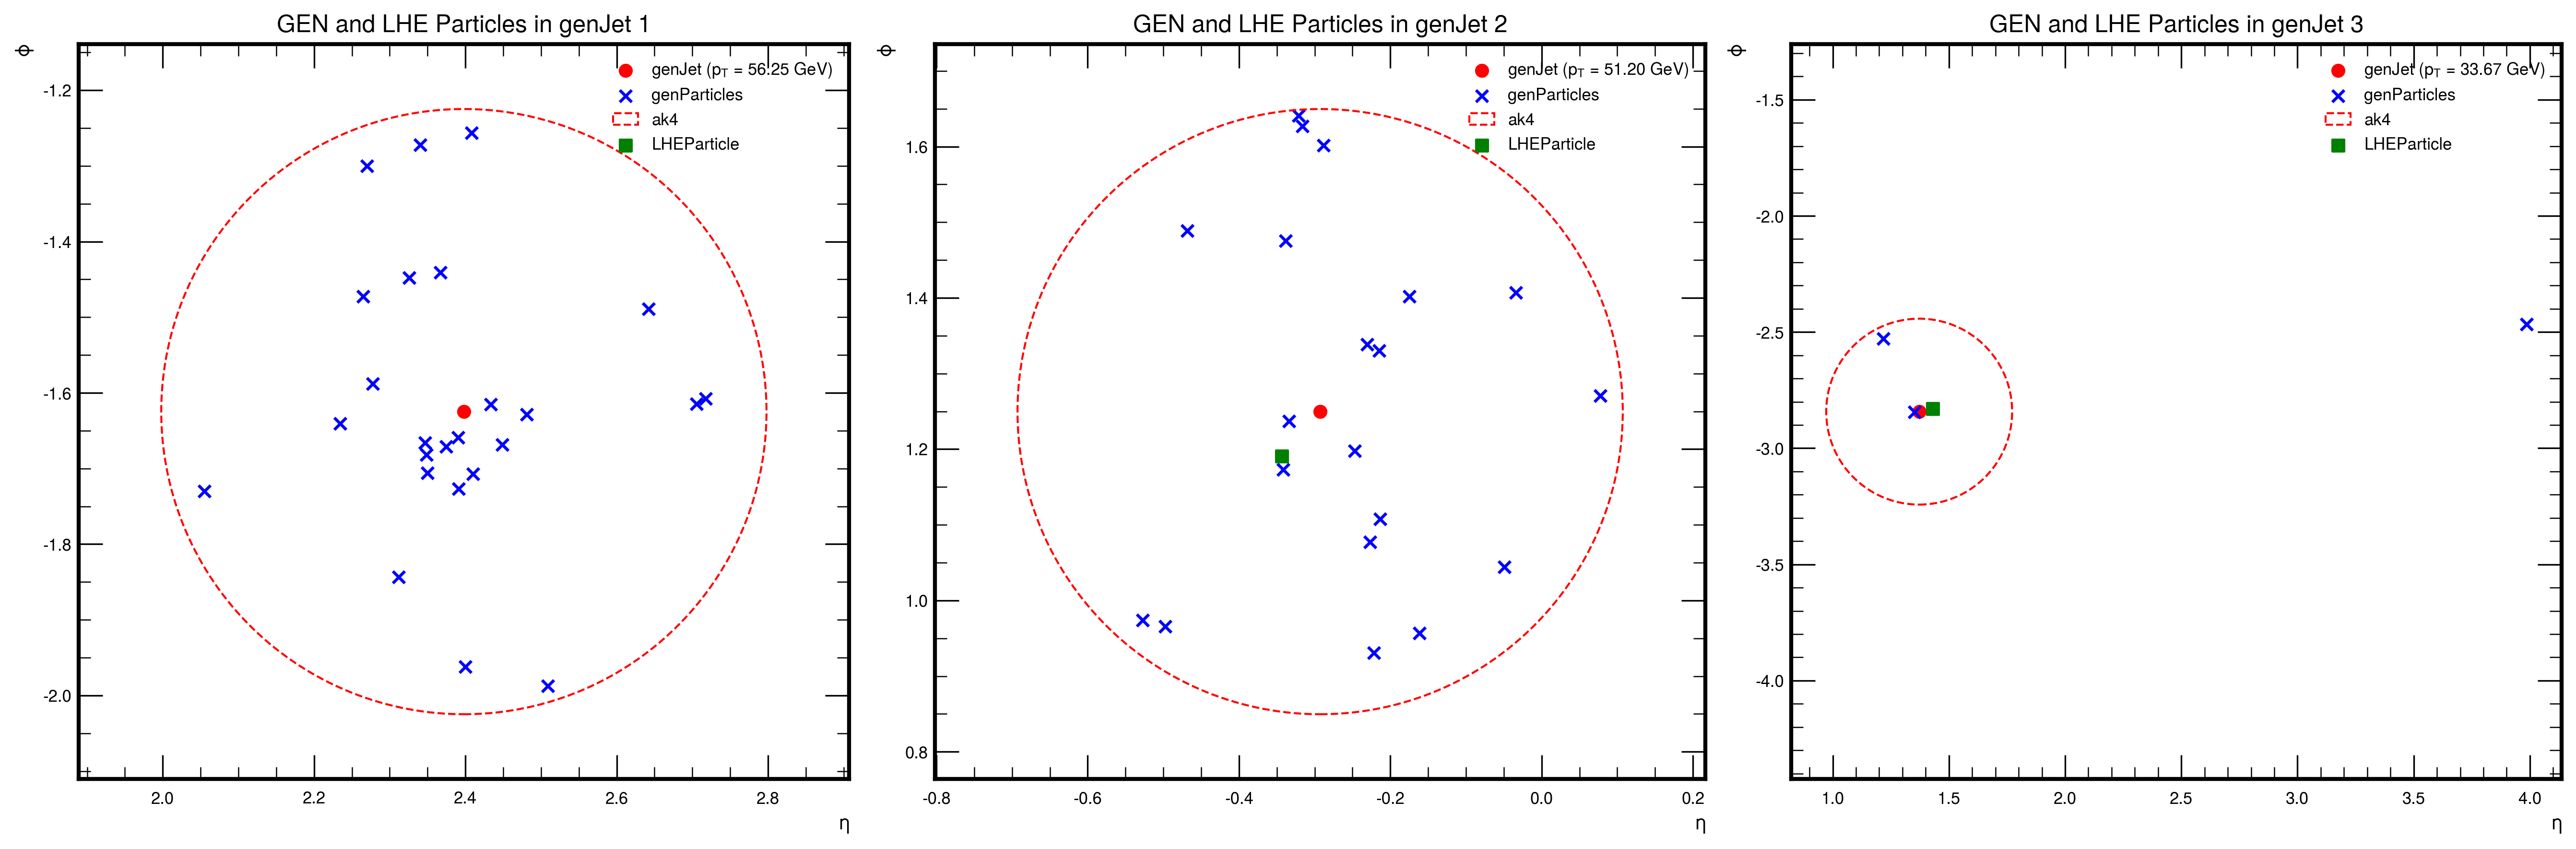

---


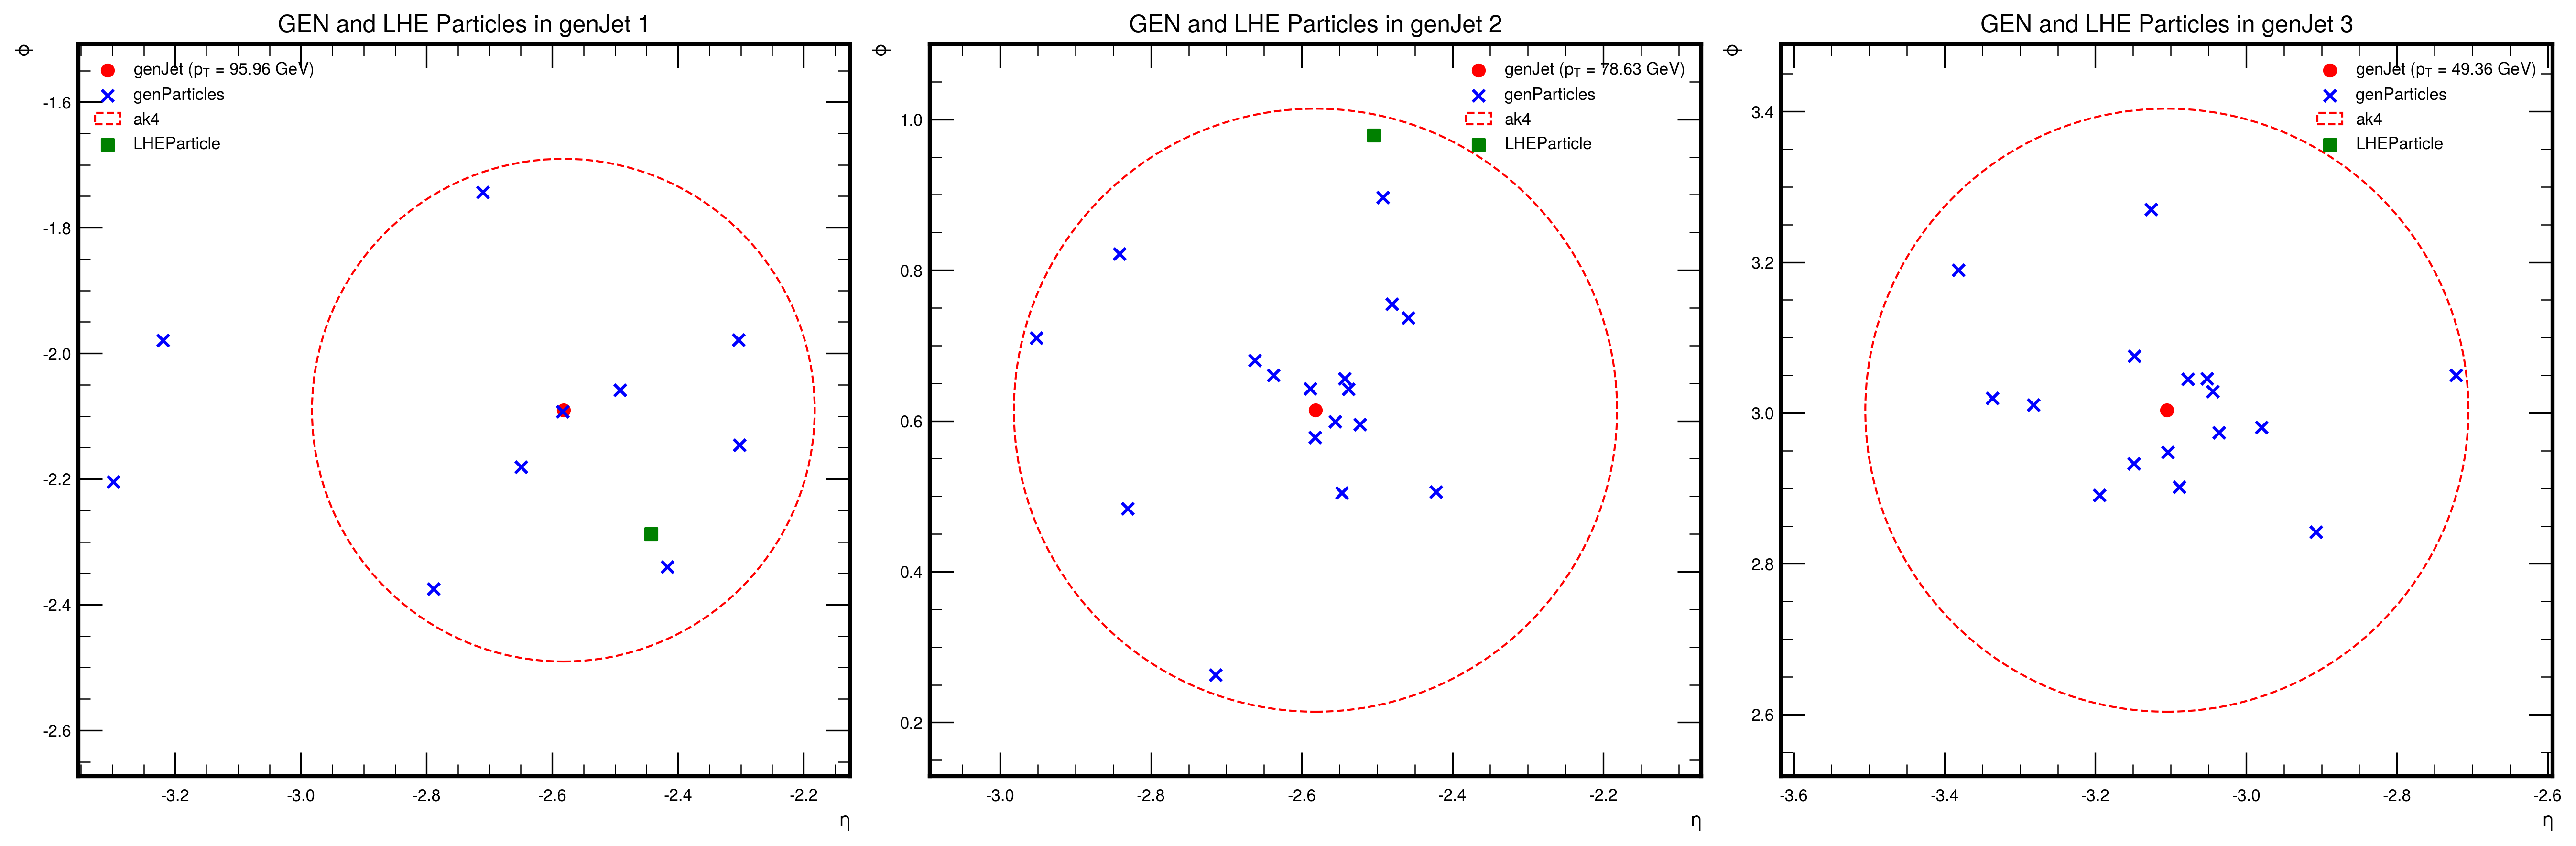

---


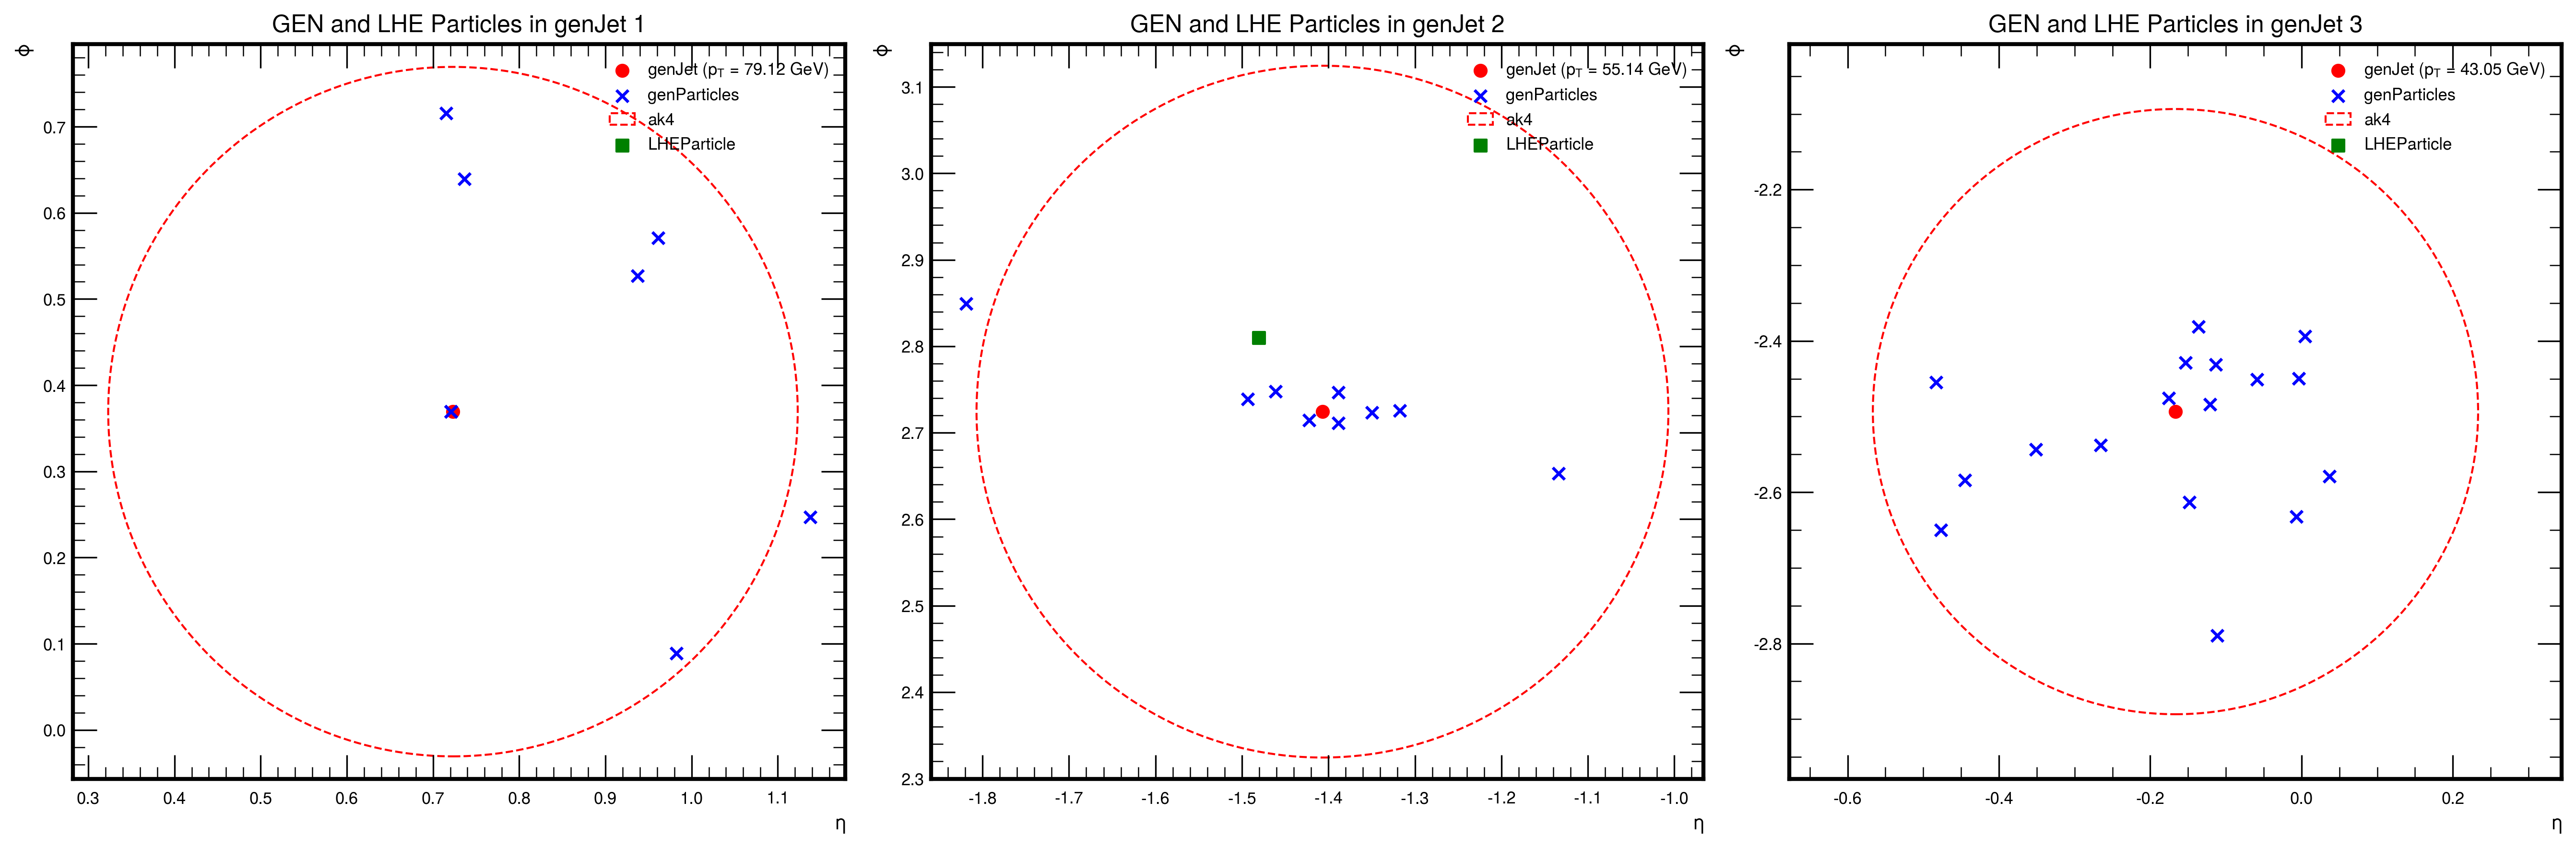

---


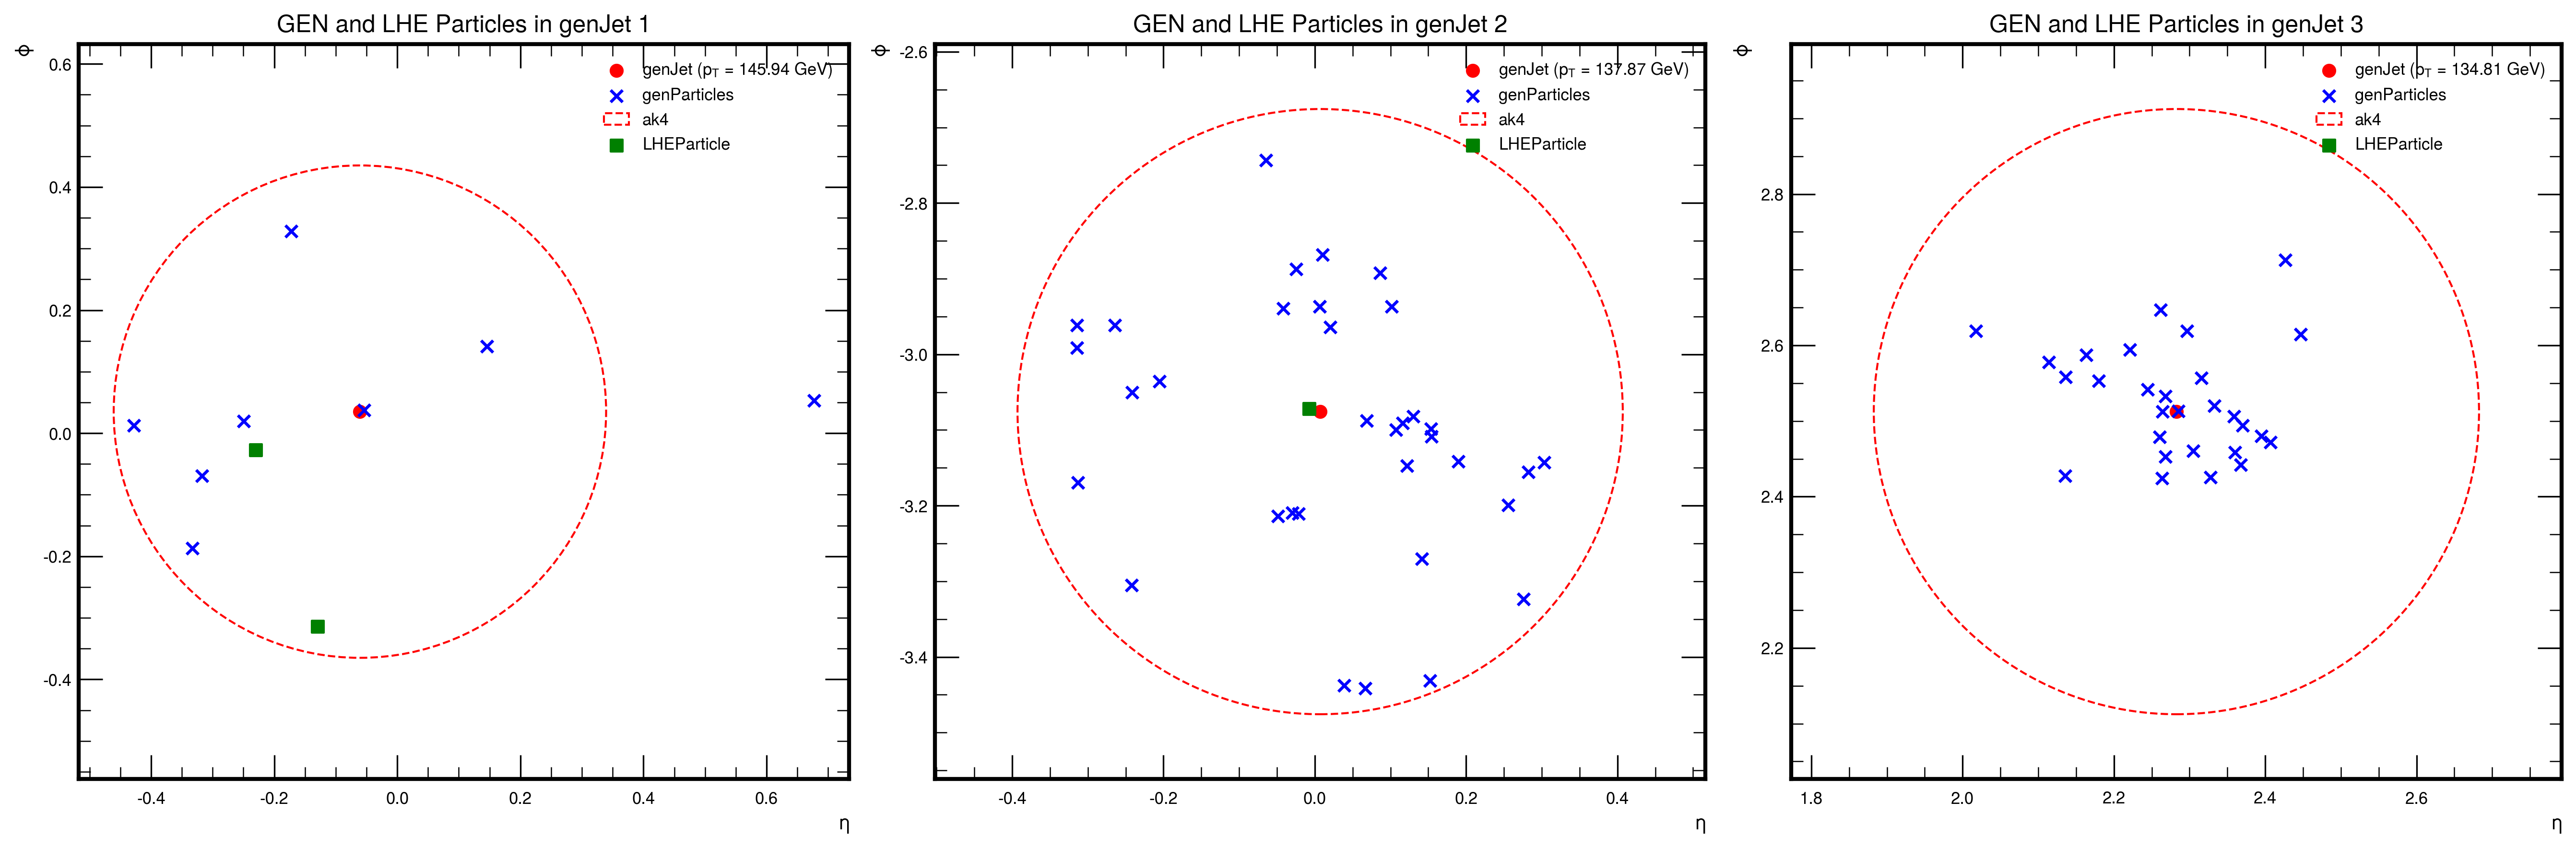

---


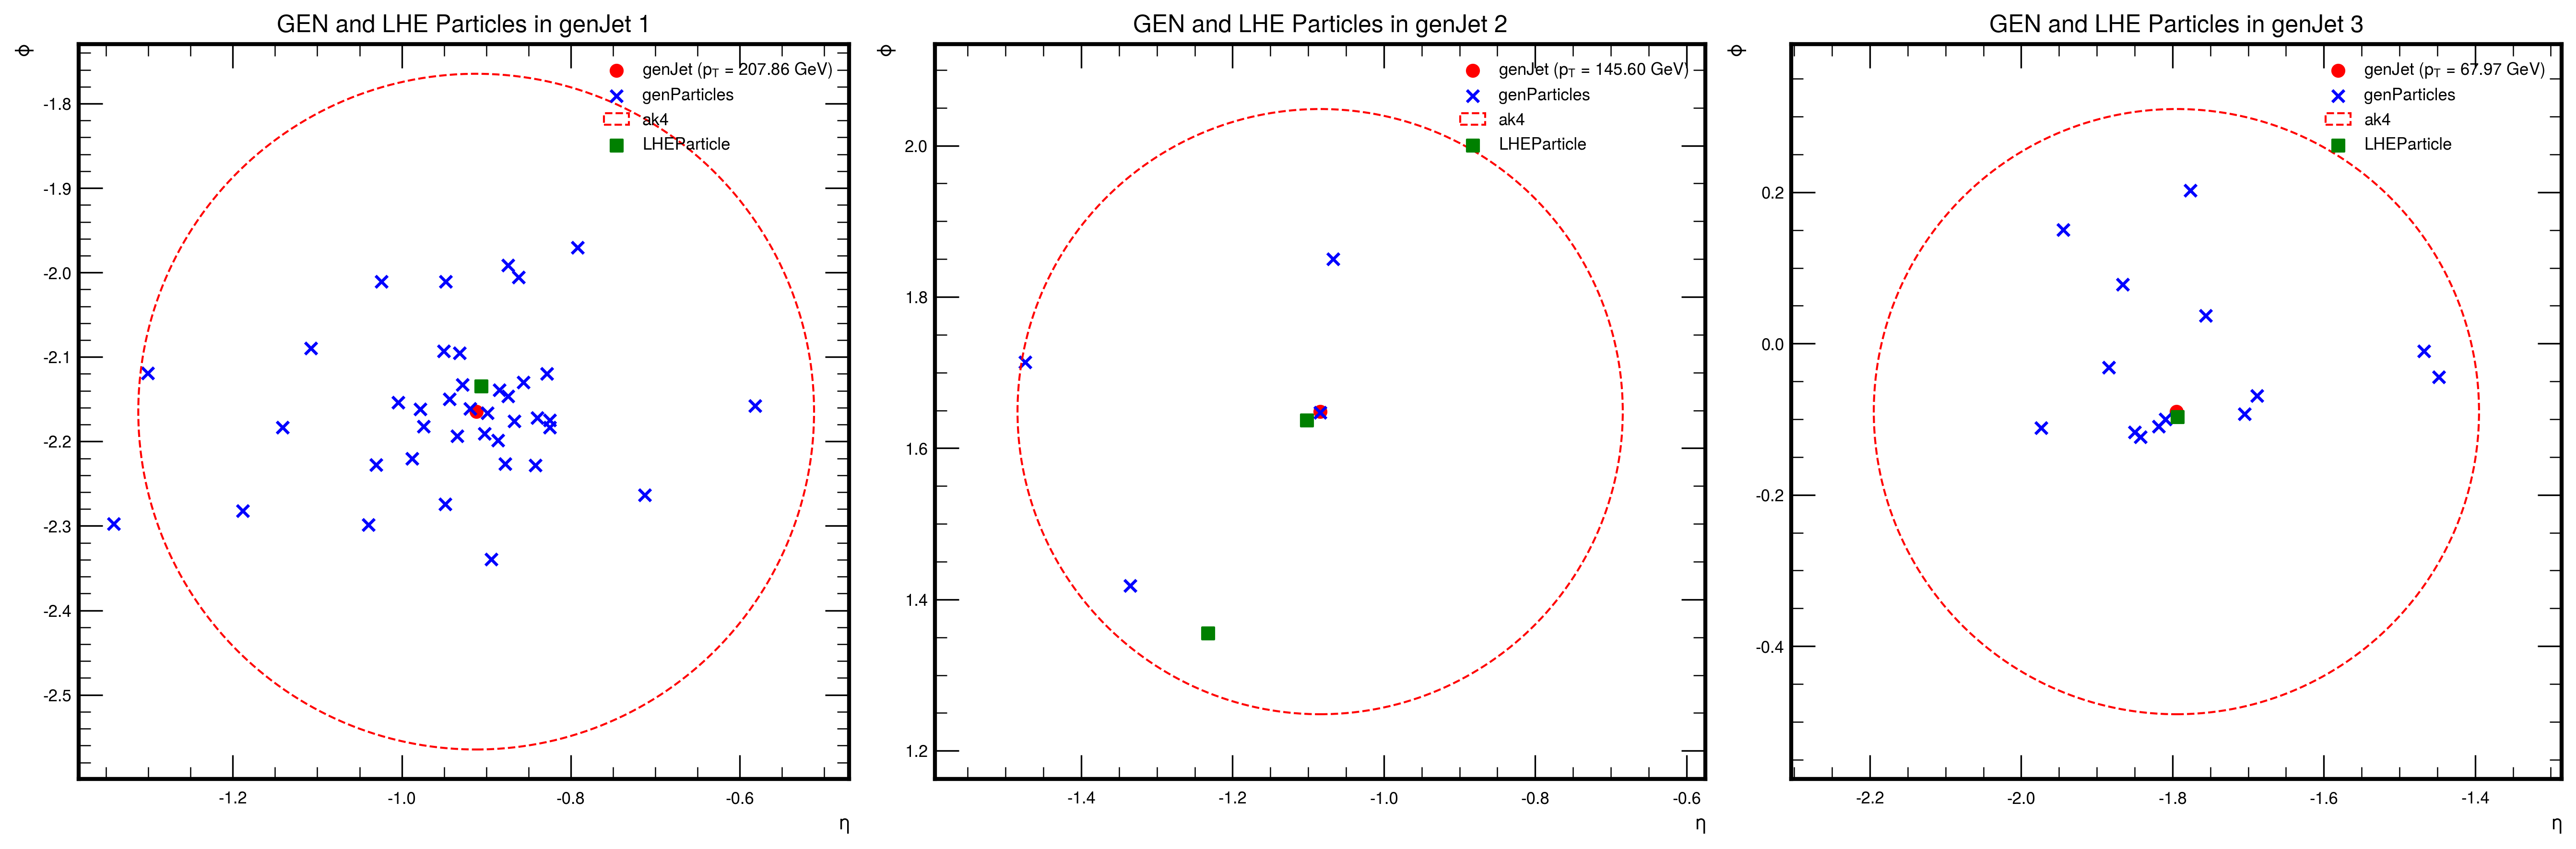

In [19]:
NJETS=3
for ev in range(10):
    genjets_pt = GenJets.GenJet_pt[ev]
    nConstituents = GenJets.GenJet_nConstituents[ev]
    constituents = GenJets.GenJet_constituents[ev]
    genParts_pt = GenParticles.GenPart_pt[ev]
    genParts_eta = GenParticles.GenPart_eta[ev]
    genParts_phi = GenParticles.GenPart_phi[ev]
    genJets_eta = GenJets.GenJet_eta[ev]
    genJets_phi = GenJets.GenJet_phi[ev]
    LHEParts_eta = LHEParticles.LHEPart_eta[ev]
    LHEParts_phi = LHEParticles.LHEPart_phi[ev]
    print("---")
#     for i in [0,1]: #set(map_genJetIdx):
#         print("jet", i, ": ")
#         genPartsInJetIndices = map_genPartsIdx[np.where(map_genJetsIdx==i)]
#         print(genJets_eta[i], genJets_phi[i])
#         print(genParts_eta[genPartsInJetIndices], genParts_phi[genPartsInJetIndices])
#         plot_particles_in_jet(genjets_pt[i], genJets_eta[i], genJets_phi[i], genParts_eta[genPartsInJetIndices], genParts_phi[genPartsInJetIndices])
    genParticles_eta_list = []
    genParticles_phi_list = []

    for i in range(NJETS):  # set(map_genJetIdx):
        genPartsInJetIndices = getJetConstituents(i, nConstituents, constituents)
        genParticles_eta_list.append(genParts_eta[genPartsInJetIndices])
        genParticles_phi_list.append(genParts_phi[genPartsInJetIndices])

    plot_particles_in_jets_withLHE(genjets_pt[:NJETS], genJets_eta[:NJETS], genJets_phi[:NJETS], genParticles_eta_list, genParticles_phi_list, LHEParts_eta, LHEParts_phi)

## 2d hist

In [20]:
# take the first two jets with high pt and do the eta>0 and eta<0 plots
NJETS=2
genPar_eta_list = [[],[]] # 0 eta pos 1 eta neg
genPar_phi_list = [[],[]]
LHEPar_eta_list = [[],[]] # 0 eta pos 1 eta neg
LHEPar_phi_list = [[],[]]
for ev in range(len(GenJets.GenJet_pt)):
    genjets_pt = GenJets.GenJet_pt[ev]
    genJets_eta = GenJets.GenJet_eta[ev]
    genJets_phi = GenJets.GenJet_phi[ev]
    nConstituents = GenJets.GenJet_nConstituents[ev]
    constituents = GenJets.GenJet_constituents[ev]
    
    genParts_pt = GenParticles.GenPart_pt[ev]
    genParts_eta = GenParticles.GenPart_eta[ev]
    genParts_phi = GenParticles.GenPart_phi[ev]

    LHEParts_eta = LHEParticles.LHEPart_eta[ev]
    LHEParts_phi = LHEParticles.LHEPart_phi[ev]
    if len(genjets_pt) < NJETS: continue
    for i in range(NJETS):
        ind = 0 if genJets_eta[i] > 0 else 1
        genPartsInJetIndices = getJetConstituents(i, nConstituents, constituents)
        genPar_eta_list[ind].extend(genParts_eta[genPartsInJetIndices] - genJets_eta[i])
        genPar_phi_list[ind].extend(fixWrap(wrapInPhi(genParts_phi[genPartsInJetIndices]),genJets_phi[i]) - genJets_phi[i])
        if np.isfinite(LHEParts_eta[i]):
            LHEPar_eta_list[ind].extend(LHEParts_eta[i] - genJets_eta[i])
            LHEPar_phi_list[ind].extend(LHEParts_phi[i] - genJets_phi[i])

#     plot_particles_in_jets_withLHE(axs, genjets_pt[:NJETS], genJets_eta[:NJETS], genJets_phi[:NJETS], genParticles_eta_list, genParticles_phi_list, LHEParts_eta, LHEParts_phi)

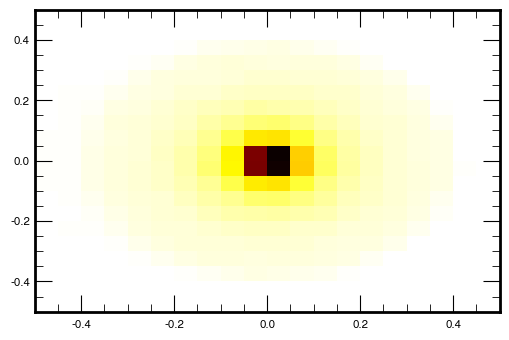

In [21]:
plt.figure(dpi=100)
plt.hist2d(genPar_eta_list[1], genPar_phi_list[1], range=[[-0.5,0.5],[-0.5,0.5]], cmap="hot_r", bins=20)
plt.show()

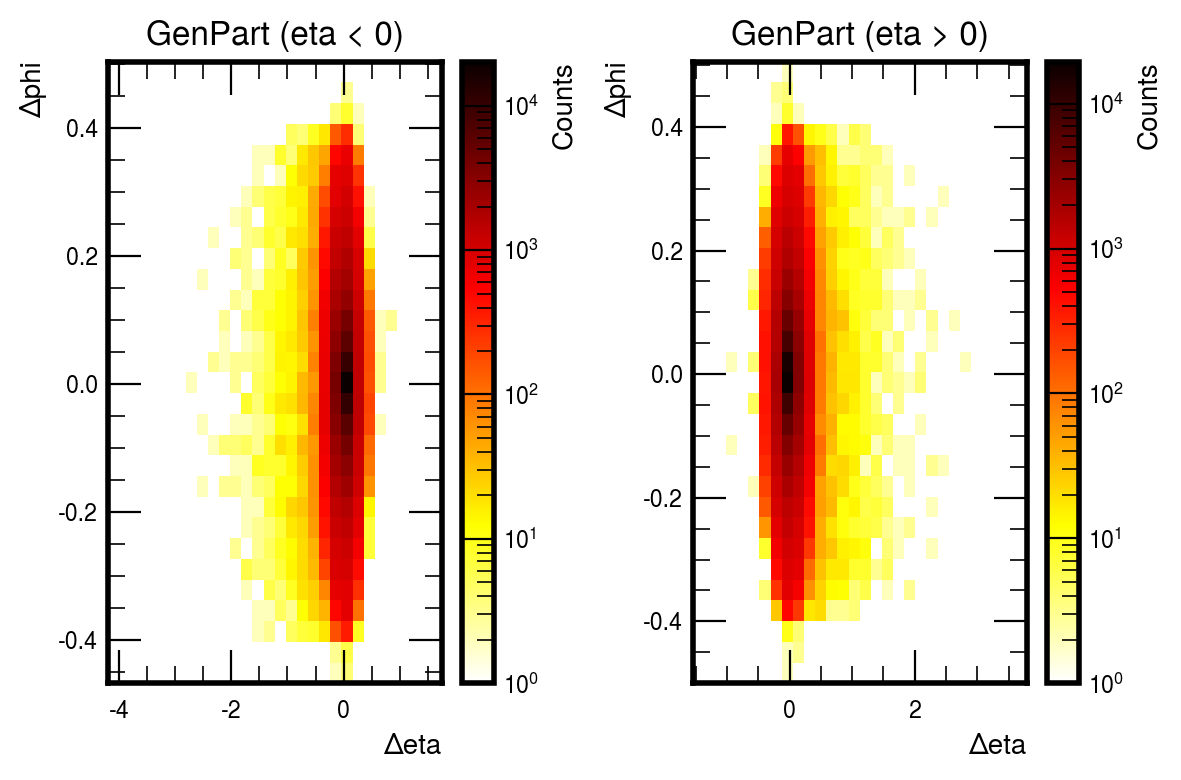

In [22]:
# Plotting the histograms
fig, axes = plt.subplots(1, 2, dpi=200)

# Plot for negative eta
h2 = axes[0].hist2d(
    genPar_eta_list[1], genPar_phi_list[1], 
    #weights=genPar_energy_list[1], 
    bins=(30, 30), cmap='hot_r', norm=mpl.colors.LogNorm()
)
axes[0].set_title('GenPart (eta < 0)')
axes[0].set_xlabel('Δeta')
axes[0].set_ylabel('Δphi')
cbar2 = plt.colorbar(h2[3], ax=axes[0])
cbar2.set_label('Counts')

# Plot for positive eta
h1 = axes[1].hist2d(
    genPar_eta_list[0], genPar_phi_list[0], 
    #weights=genPar_energy_list[0], 
    bins=(30, 30), cmap='hot_r', norm=mpl.colors.LogNorm()
)
axes[1].set_title('GenPart (eta > 0)')
axes[1].set_xlabel('Δeta')
axes[1].set_ylabel('Δphi')
cbar1 = plt.colorbar(h1[3], ax=axes[1])
cbar1.set_label('Counts')

plt.tight_layout()
plt.show()


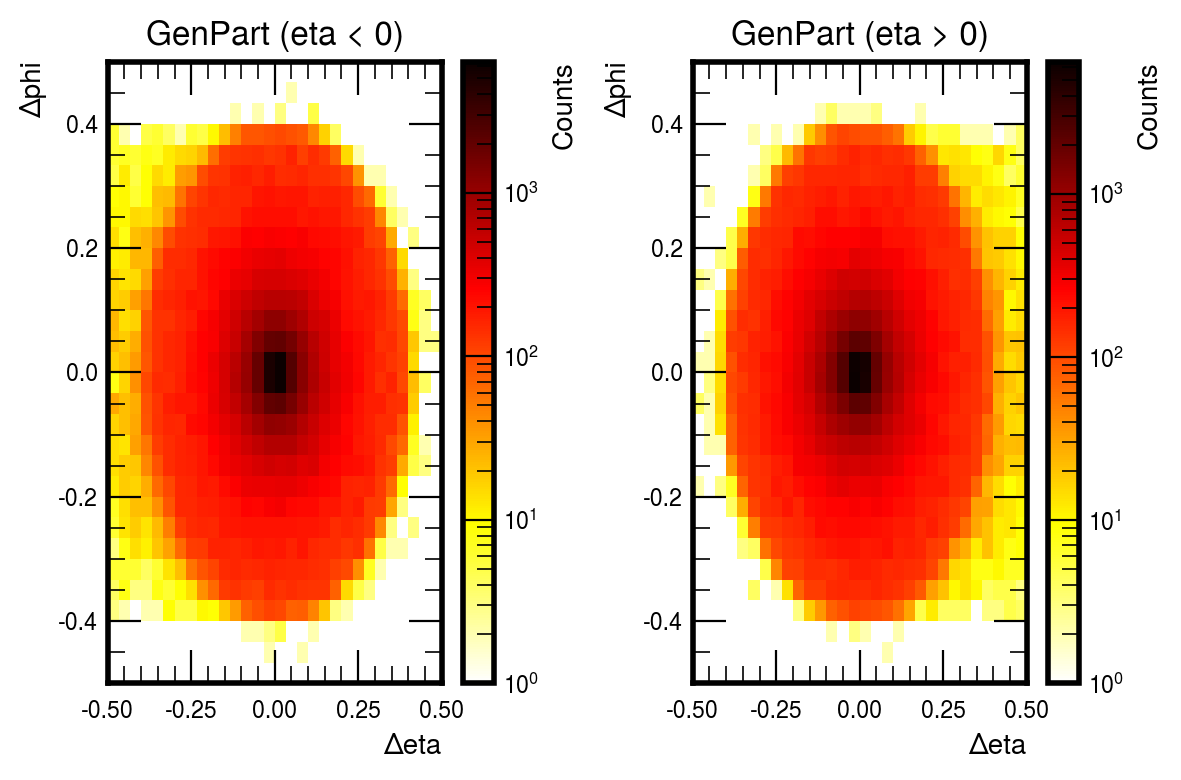

In [23]:
# Plotting the histograms
fig, axes = plt.subplots(1, 2, dpi=200)

# Plot for negative eta
h2 = axes[0].hist2d(
    genPar_eta_list[1], genPar_phi_list[1], 
    #weights=genPar_energy_list[1], 
    range=[[-0.5,0.5],[-0.5,0.5]], 
    bins=(30, 30), cmap='hot_r', norm=mpl.colors.LogNorm()
)
axes[0].set_title('GenPart (eta < 0)')
axes[0].set_xlabel('Δeta')
axes[0].set_ylabel('Δphi')
cbar2 = plt.colorbar(h2[3], ax=axes[0])
cbar2.set_label('Counts')

# Plot for positive eta
h1 = axes[1].hist2d(
    genPar_eta_list[0], genPar_phi_list[0], 
    #weights=genPar_energy_list[0], 
    range=[[-0.5,0.5],[-0.5,0.5]], 
    bins=(30, 30), cmap='hot_r', norm=mpl.colors.LogNorm()
)
axes[1].set_title('GenPart (eta > 0)')
axes[1].set_xlabel('Δeta')
axes[1].set_ylabel('Δphi')
cbar1 = plt.colorbar(h1[3], ax=axes[1])
cbar1.set_label('Counts')

plt.tight_layout()
plt.show()

In [24]:
NJETS = 2
genPar_eta_list = [[], []]  # 0 eta pos 1 eta neg
genPar_phi_list = [[], []]
genPar_energy_list = [[], []]
genGet_eta_list = [[], []]

for ev in range(1000):
    genjets_pt = GenJets.GenJet_pt[ev]
    genJets_eta = GenJets.GenJet_eta[ev]
    genJets_phi = GenJets.GenJet_phi[ev]
    nConstituents = GenJets.GenJet_nConstituents[ev]
    constituents = GenJets.GenJet_constituents[ev]
    
    genParts_pt = GenParticles.GenPart_pt[ev]
    genParts_eta = GenParticles.GenPart_eta[ev]
    genParts_phi = GenParticles.GenPart_phi[ev]

    if len(genjets_pt) < NJETS: continue
    for i in range(NJETS):
        ind = 0 if genJets_eta[i] > 0 else 1
        genPartsInJetIndices = getJetConstituents(i, nConstituents, constituents)
        eta_diff = genParts_eta[genPartsInJetIndices] - genJets_eta[i]
        phi_diff = fixWrap(wrapInPhi(genParts_phi[genPartsInJetIndices]), genJets_phi[i]) - genJets_phi[i]
        energy = genParts_pt[genPartsInJetIndices] * np.cosh(genParts_eta[genPartsInJetIndices])

        genPar_eta_list[ind].extend(eta_diff)
        genPar_phi_list[ind].extend(phi_diff)
        genPar_energy_list[ind].extend(energy)
        
        genGet_eta_list[ind].extend([genJets_eta[i]]*len(eta_diff))

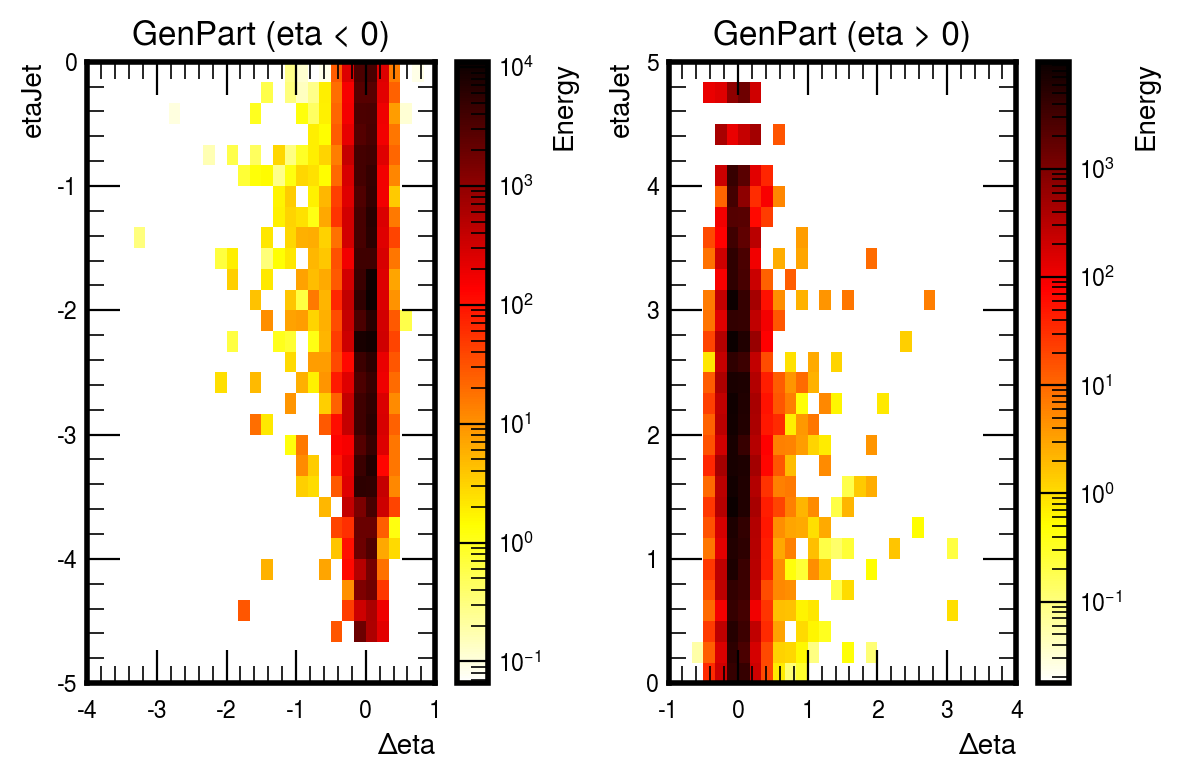

In [25]:
# Plotting the histograms
fig, axes = plt.subplots(1, 2, dpi=200)

# Plot for positive eta
h1 = axes[1].hist2d(
    genPar_eta_list[0], genGet_eta_list[0], # hist2d: genPart_deta , genJet_eta
    weights=genPar_energy_list[0], 
    range=[[-1,4],[0,5]], 
    bins=(30, 30), cmap='hot_r', norm=mpl.colors.LogNorm()
)
axes[1].set_title('GenPart (eta > 0)')
axes[1].set_xlabel('Δeta')
axes[1].set_ylabel('etaJet')
cbar1 = plt.colorbar(h1[3], ax=axes[1])
cbar1.set_label('Energy')

# Plot for negative eta
h2 = axes[0].hist2d(
    genPar_eta_list[1], genGet_eta_list[1], 
    weights=genPar_energy_list[1], 
    range=[[-4,1],[-5,0]], 
    bins=(30, 30), cmap='hot_r', norm=mpl.colors.LogNorm()
)
axes[0].set_title('GenPart (eta < 0)')
axes[0].set_xlabel('Δeta')
axes[0].set_ylabel('etaJet')
cbar2 = plt.colorbar(h2[3], ax=axes[0])
cbar2.set_label('Energy')

plt.tight_layout()
plt.show()

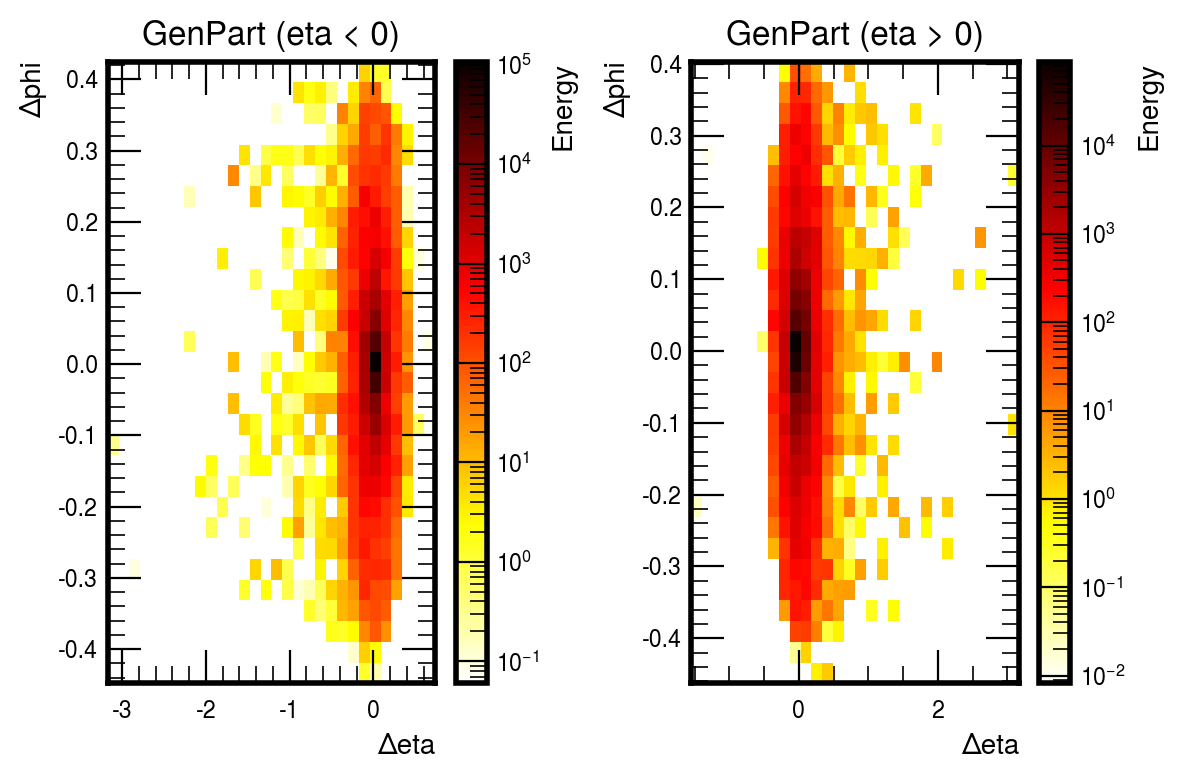

In [26]:
# Plotting the histograms
fig, axes = plt.subplots(1, 2, dpi=200)

# Plot for positive eta
h1 = axes[1].hist2d(
    genPar_eta_list[0], genPar_phi_list[0], 
    weights=genPar_energy_list[0], 
#     range=[[-0.5,0.5],[-0.5,0.5]], 
    bins=(30, 30), cmap='hot_r', norm=mpl.colors.LogNorm()
)
axes[1].set_title('GenPart (eta > 0)')
axes[1].set_xlabel('Δeta')
axes[1].set_ylabel('Δphi')
cbar1 = plt.colorbar(h1[3], ax=axes[1])
cbar1.set_label('Energy')

# Plot for negative eta
h2 = axes[0].hist2d(
    genPar_eta_list[1], genPar_phi_list[1], 
    weights=genPar_energy_list[1], 
#     range=[[-0.5,0.5],[-0.5,0.5]], 
    bins=(30, 30), cmap='hot_r', norm=mpl.colors.LogNorm()
)
axes[0].set_title('GenPart (eta < 0)')
axes[0].set_xlabel('Δeta')
axes[0].set_ylabel('Δphi')
cbar2 = plt.colorbar(h2[3], ax=axes[0])
cbar2.set_label('Energy')

plt.tight_layout()
plt.show()

## eta studies

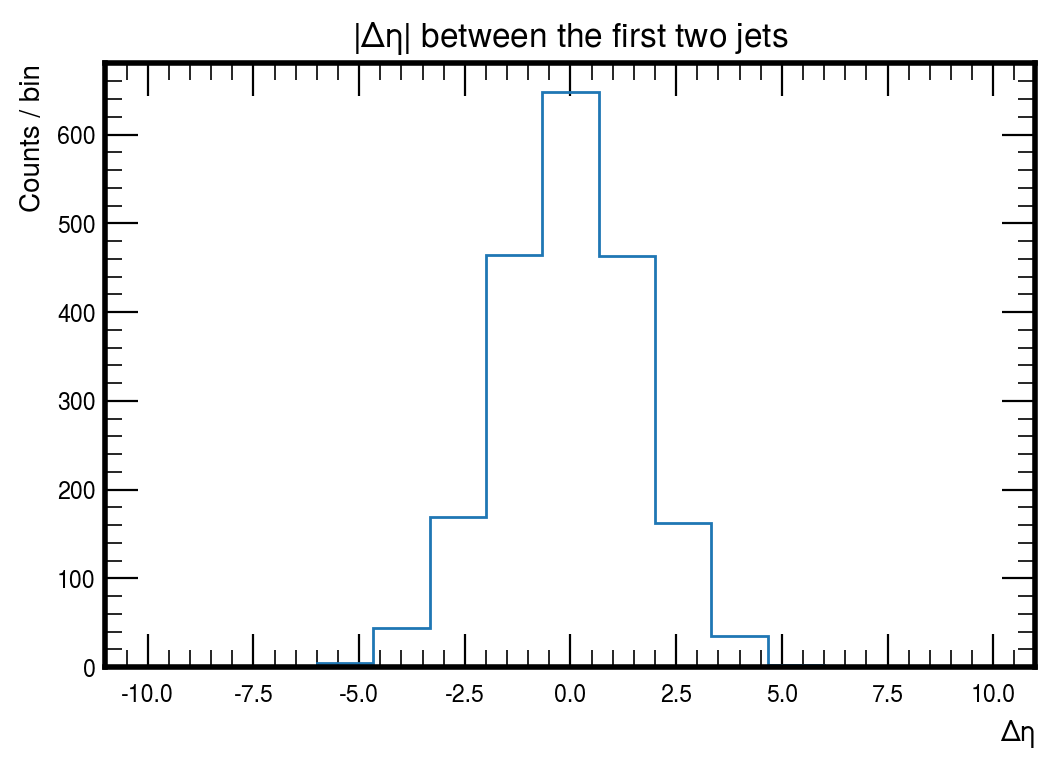

In [31]:
PTMIN = 100
deta = []
eta = []
for jets_eta_ev, jets_pt_ev in zip(GenJets.GenJet_eta, GenJets.GenJet_pt):
    if jets_pt_ev[0] > PTMIN and jets_pt_ev[1] > PTMIN:
        deta.append((jets_eta_ev[0] - jets_eta_ev[1]))
        eta.append(jets_eta_ev[0])

plt.figure(dpi=200)
plt.title(r"|$\Delta\eta$| between the first two jets")
plt.xlabel(r"$\Delta\eta$")
plt.ylabel('Counts / bin')

plt.hist(deta, histtype="step", bins=15, range=(-10,10))

#plt.yscale("log")
plt.show()

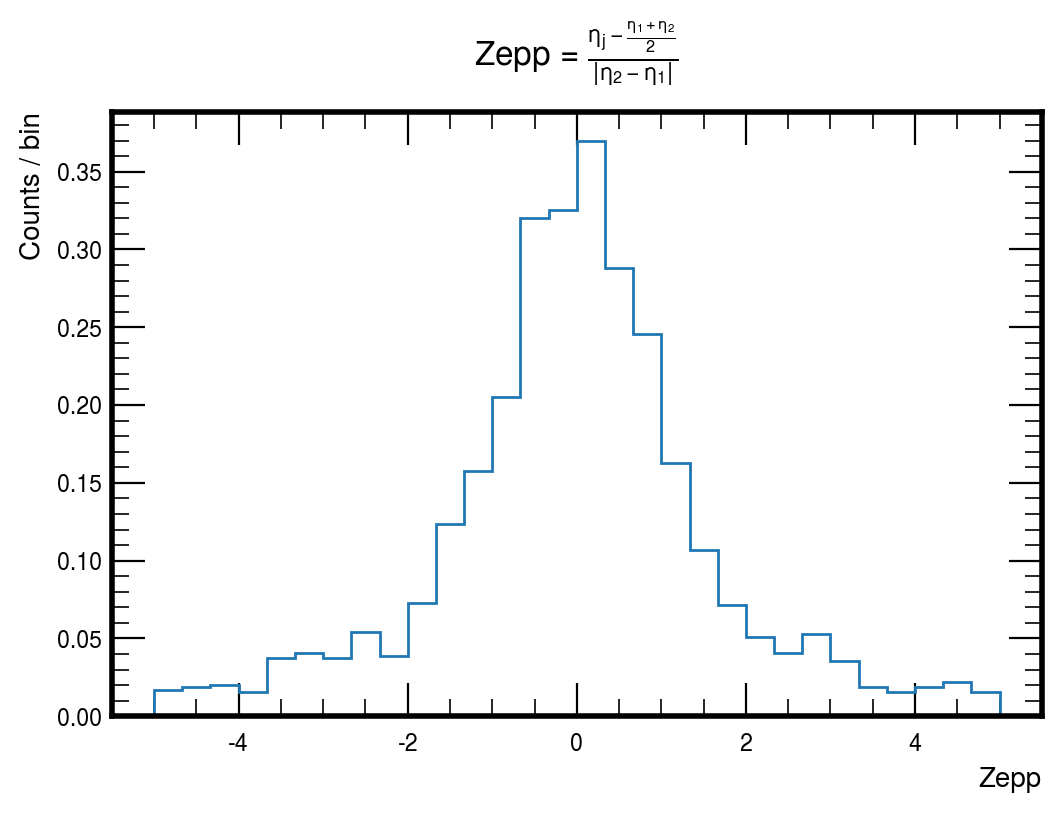

In [30]:
zepp = []
for jets_eta_ev, jets_pt_ev in zip(GenJets.GenJet_eta, GenJets.GenJet_pt):
    if jets_pt_ev[0] > PTMIN and jets_pt_ev[1] > PTMIN and len(jets_eta_ev)>2:
        eta1 = jets_eta_ev[0]
        eta2 = jets_eta_ev[1]
        etaj = jets_eta_ev[2]
        zepp.append((etaj - (eta1 + eta2)/2)/abs(eta2 - eta1))

plt.figure(dpi=200)
plt.title(r"Zepp = $\frac{\eta_j - \frac{\eta_1 + \eta_2}{2}}{|\eta_2 - \eta_1|}$", y=1.05)
plt.xlabel("Zepp")
plt.ylabel('Counts / bin')

plt.hist(zepp, histtype="step", bins=30, range=(-5,5),density=True)

#plt.yscale("log")
plt.show()